# Predicting Flight Delays
##### Team: House Spark
##### Phase III Lead: Anuradha (Annie) Passan, Lord Commander of Moore's Law, King of the Cloud, Warden of CUDA, sits on the Iron Throne

# Notebook Setup

In [0]:
%pip install timezonefinder
%pip install tzfpy

Python interpreter will be restarted.
  Installing build dependencies: started


In [0]:
# General 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px
import sys
from statistics import mean

# PySpark 
from pyspark.sql.functions import col,isnan,when,count
from pyspark.sql.functions import regexp_replace

# SQL Functions
from pyspark.sql import functions as f
from pyspark.sql.functions import monotonically_increasing_id, to_timestamp, to_utc_timestamp, to_date, udf
from pyspark.sql.functions import isnan, when, count, col, isnull, percent_rank, first
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType, DecimalType
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
from pyspark.streaming import StreamingContext
from pyspark.sql import Row
from functools import reduce
from pyspark.sql.functions import rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql import DataFrame
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import DenseMatrix, Vectors, VectorUDT, DenseVector, SparseVector
from pyspark.sql.functions import row_number

# ML
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest

# Misc 
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from timezonefinder import TimezoneFinder
from tzfpy import get_tz

java.lang.RuntimeException: abort: DriverClient destroyed
	at com.databricks.backend.daemon.driver.DriverClient.$anonfun$poll$3(DriverClient.scala:602)
	at scala.concurrent.Future.$anonfun$flatMap$1(Future.scala:307)
	at scala.concurrent.impl.Promise.$anonfun$transformWith$1(Promise.scala:41)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at com.databricks.threading.NamedExecutor$$anon$2.$anonfun$run$1(NamedExecutor.scala:360)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:401)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:158)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:399)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:396)
	at com.databricks.threading.NamedExecutor.withAttributionContext(NamedExecutor.scala:287)
	at com.databricks.threading.NamedExecutor$$anon$2.run(NamedExecutor.scala:359)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

In [0]:
# Display and define where mids-w261 is located
data_BASE_DIR = "dbfs:/mnt/mids-w261/"
# display(dbutils.fs.ls(f"{data_BASE_DIR}"))

# Inspect the Mount's Final Project folder 
data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"
# display(dbutils.fs.ls(f"{data_BASE_DIR}"))

In [0]:
blob_container = "housestark" # The name of your container created in https://portal.azure.com
storage_account = "neilp" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261_s1g4" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261_s1g4_key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

In [0]:
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
# spark.read.parquet(f"{blob_url}/df_main_fullClean")
# df = spark.read.parquet(f"{blob_url}/df_main_3m")
# df = spark.read.parquet(f"{blob_url}/df_main_fullClean")
df = spark.read.parquet(f"{blob_url}/df_main_fullClean_EDA")

In [0]:
# def df_cast(df):
  
#   df = df.withColumn('DEP_DELAY', col('DEP_DELAY').cast('int')) \
#              .withColumn('DEP_DELAY_NEW', col('DEP_DELAY_NEW').cast('int')) \
#              .withColumn('CANCELLED', col('CANCELLED').cast('int')) \
#              .withColumn('DISTANCE', col('DISTANCE').cast('int')) \
#              .withColumn('DEP_DELAY', col('DEP_DELAY').cast('int')) \
#              .withColumn('elevation_ft', col('elevation_ft').cast('int')) \
#              .withColumn('origin_HourlyAltimeterSetting', col('origin_HourlyAltimeterSetting').cast('float')) \
#              .withColumn('origin_HourlyDewPointTemperature', col('origin_HourlyDewPointTemperature').cast('int')) \
#              .withColumn('origin_HourlyDryBulbTemperature', col('origin_HourlyDryBulbTemperature').cast('int')) \
#              .withColumn('origin_HourlyPrecipitation', col('origin_HourlyPrecipitation').cast('float')) \
#              .withColumn('origin_HourlyPressureChange', regexp_replace('origin_HourlyPressureChange', '[^-.0-9]+', '')) \
#              .withColumn('origin_HourlyPressureChange', col('origin_HourlyPressureChange').cast('float')) \
#              .withColumn('origin_HourlyPressureTendency', col('origin_HourlyPressureTendency').cast('int')) \
#              .withColumn('origin_HourlyRelativeHumidity', col('origin_HourlyRelativeHumidity').cast('int')) \
#              .withColumn('origin_HourlySeaLevelPressure', col('origin_HourlySeaLevelPressure').cast('float')) \
#              .withColumn('origin_HourlyStationPressure', col('origin_HourlyStationPressure').cast('float')) \
#              .withColumn('origin_HourlyVisibility', col('origin_HourlyVisibility').cast('float')) \
#              .withColumn('origin_HourlyWetBulbTemperature', col('origin_HourlyWetBulbTemperature').cast('int')) \
#              .withColumn('origin_HourlyWindDirection', col('origin_HourlyWindDirection').cast('int')) \
#              .withColumn('origin_HourlyWindGustSpeed', col('origin_HourlyWindGustSpeed').cast('int')) \
#              .withColumn('origin_HourlyWindSpeed', col('origin_HourlyWindSpeed').cast('int')) \
#              .withColumn('origin_AWND', col('origin_AWND').cast('float')) \
#              .withColumn('origin_CDSD', col('origin_CDSD').cast('int')) \
#              .withColumn('origin_CLDD', col('origin_CLDD').cast('int')) \
#              .withColumn('origin_DSNW', col('origin_DSNW').cast('int')) \
#              .withColumn('origin_HDSD', col('origin_HDSD').cast('int')) \
#              .withColumn('origin_HTDD', col('origin_HTDD').cast('int')) \
#              .withColumn('dest_HourlyAltimeterSetting', col('dest_HourlyAltimeterSetting').cast('float')) \
#              .withColumn('dest_HourlyDewPointTemperature', col('dest_HourlyDewPointTemperature').cast('int')) \
#              .withColumn('dest_HourlyDryBulbTemperature', col('dest_HourlyDryBulbTemperature').cast('int')) \
#              .withColumn('dest_HourlyPrecipitation', col('dest_HourlyPrecipitation').cast('float')) \
#              .withColumn('dest_HourlyPressureChange', regexp_replace('dest_HourlyPressureChange', '[^-.0-9]+', '')) \
#              .withColumn('dest_HourlyPressureChange', col('dest_HourlyPressureChange').cast('float')) \
#              .withColumn('dest_HourlyPressureTendency', col('dest_HourlyPressureTendency').cast('int')) \
#              .withColumn('dest_HourlyRelativeHumidity', col('dest_HourlyRelativeHumidity').cast('int')) \
#              .withColumn('dest_HourlySeaLevelPressure', col('dest_HourlySeaLevelPressure').cast('float')) \
#              .withColumn('dest_HourlyStationPressure', col('dest_HourlyStationPressure').cast('float')) \
#              .withColumn('dest_HourlyVisibility', col('dest_HourlyVisibility').cast('float')) \
#              .withColumn('dest_HourlyWetBulbTemperature', col('dest_HourlyWetBulbTemperature').cast('int')) \
#              .withColumn('dest_HourlyWindDirection', col('dest_HourlyWindDirection').cast('int')) \
#              .withColumn('dest_HourlyWindGustSpeed', col('dest_HourlyWindGustSpeed').cast('int')) \
#              .withColumn('dest_HourlyWindSpeed', col('dest_HourlyWindSpeed').cast('int')) \
#              .withColumn('dest_AWND', col('dest_AWND').cast('float')) \
#              .withColumn('dest_CDSD', col('dest_CDSD').cast('int')) \
#              .withColumn('dest_CLDD', col('dest_CLDD').cast('int')) \
#              .withColumn('dest_DSNW', col('dest_DSNW').cast('int')) \
#              .withColumn('dest_HDSD', col('dest_HDSD').cast('int')) \
#              .withColumn('dest_HTDD', col('dest_HTDD').cast('int')) \
#              .withColumn('Year', f.year(col('scheduled_departure_UTC'))) \
#              .withColumn('RoundedDate', f.to_date(col('scheduled_departure_UTC'))) \
#              .withColumn('dep_delay_15', f.when(f.col('DEP_DELAY_NEW') >= 15, 1).otherwise(0))  \
#              .withColumn('dep_delay_binary', f.when(f.col('DEP_DELAY_NEW') > 0, 1).otherwise(0)) 

#   return df

# EDA (III): Trends and Exploration

For phase III, we continued with exploratory data analysis (EDA) with increased focus on categorical variables to get a better understanding of the data to help inform our model parameters. 

Starting with our C19 time periods, we see that throughout 2019 flights went through their typical seasonal trends of increased delays during holiday and summer periods, however as 2020 rolled around, we saw a spike in delays during February 2020 likely due to increased precautions on international flights. Starting Mid-March 2020, we saw a significant drop off in delays which can be attributed to the significant decrease in the volume of air travel. This volume and percent of delays starts to pick back up during the 2020 summer period however it is not close to the levels of prior periods (pre-2020). We also saw a significant increase in cancellations during the March 2020 - June 2020 period as airlines were faced with empty planes and unsold seats. Following June 2020, we lower levels of cancellations as airlines adjusted their operations to account for the temporary decrease in air travel volume. Looking at 2020 year-end, we see further increases in delays as volume picked up and people looked to visit family for the holidays after months of lock downs. Our feature engineered C19 variable ('C19') should account for these trends given that this is not a typical natural trend but more of a black swan event. 

Looking at delays by distance groups (variable: 'DISTANCE_GROUP'), we see shorter flights (distance group <= 3) have a lower percent of cancellations then than longer flights (distance group >= 4). However this trend is opposite for cancellations where longer distance flights are less likely to be cancelled, this trend is intuitive. These variable would be beneficial to include in our models. 

For delays and cancellations by airport type (variable: 'type'), there are clear trends between smaller and larger airports where the latter are more likely to have delays and the former are more likely to have cancellations. We should include this variable in our model. There is a single record where 'type' = 'seabase_plane', this record can be dropped as it will introduce noise. 

Turning to delays by State (variable: 'STATE'), Delaware is a clear outlier where it has double the percentage and cancelled flights. Digging into this further, this is to due to the sole Commercial (i.e. passenger) airport ILG in Wilmington. This airport only held 100 flights from a sole carrier, Frontier, during 2015 and no other flights during other periods. Looking at the history of this airport, it is not a traditional commercial airport and airlines have come and gone in service during its history. We should consider dropping the records associated with this airport ('ORIGIN' = 'ILG'). Delaware is surrounded by Baltimore, DC, and Philadelphia and Delawarians likely travel to these major hubs for commercial air travel. The trends in delays and cancellations looks reasonable with other states - we can consider dropping this variable from our models for performance reasons if does not improve the results during the sample.

For delays and cancellations by Airline (variable: 'OP_UNIQUE_CARRIER') - there are clear trends where some airlines are more likely to be delayed and/or cancelled than others. The trend appears to be premium airlines (e.g., Hawaiian) are likely to have delays compared to budget airlines (e.g., Frontier). We should consider keeping this variable in our models. 

Looking at delays by origin airport (variable: 'ORIGIN'), there are clear outliers for 'ORIGIN' codes ILG, CDB, TKI, ENV, YNG. ILG we've covered as it is not a traditional passenger airport and should be dropped. CDB is also not a traditional passanger airport - it was used by Alaska Airlines temporarily as a stop from 2020 until the Summer of 2021. These records could be removed. Airports TKI, ENV, YNG also have 1, 1, and 2 records, respectively and should be dropped as they just introduce noise. Dropping these records will allow us to not have the need to include 'ORIGIN' in our model for performance reasons. 

For delays and cancellations by origin airport ID (variable: 'ORIGIN_AIRPORT_ID'), there are clear outliers as well. For the following 'ORIGIN_AIRPORT_ID', we've observed the following related to delays:
  - 12320 is Frontier flights from Delaware - ILG. We've already decided to remove these records for reasons above. 
  - 15235 is the seabase_plane airport which we've already decided to remove for reasons above. 
  - 11563 is a small regional airport in Elko, NV (EKO), it has a record of 1 and can be removed because it is noise.
  - 16133 YNG airport - in January 2018, Allegiant Air ceased all scheduled flight operations to Youngstown. The airport has been without commercial aviation  
         service since that time, and lost its "primary airport" status with the FAA as a result. We should remove these records as it introduces noise going              forward. 
  - 10917 is ORIGIN code 'CDB', we've already decided to remove these records for reasons above. 
  
For the following 'ORIGIN_AIRPORT_ID', we've observed the following related to cancellations:
  - 10361 is a small airport, 30K passengers 2019 - 2022, non-hub primary commercial service facility. We can leave in given passenger volumes. 
  - 13388 is a small airport in yosemite, primary/non-hub commercial airport. In 2020 it lost its commercial airline designation and thus could be removed.
  - 15041 is a small airport in Sun Valley, 40K passengers per year. We can leave in given passenger volume. 
  - 10930 is a small airport that only has one flight per day, probably gets cancelled because of not enough people. We can remove as it introduces noise.
  
  If we remove the records above, we can drop 'ORIGIN_AIRPORT_ID' from our models for performance reasons. These records also led us to dig further into FAA airport designations. Airports can be designated commercial (i.e., traditional passanger airport) and non-commercial (reliever, general aviation, etc.) by FAA and this is reviewed regularly. These commercial airports also have subdesignations (i.e., Small, Medium, Large, Non-hub, and Non-Primary). If we are able to source and ingest a clean dataset with these FAA designations, we will incorporate it into our model in future phases to determine if it further improves performance.
  https://www.faa.gov/airports/planning_capacity/passenger_allcargo_stats/passenger/previous_years#2020
  
  https://www.faa.gov/airports/planning_capacity/categories

Looking at delays and cancellations by city (variable: 'ORIGIN_CITY_NAME'), there are clear outliers however they will be accounted for based on our comments for 'ORIGIN' and 'ORIGIN_AIRPORT_ID'. We can drop this variable from our model for performance reasons.

d
### Functions for EDA

In [0]:
df = df.filter(col('Year') < 2021)
display(df)

local_timestamp,timezone,scheduled_departure_UTC,rounded_depTimestamp,label,Year,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME_BLK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,dep_delay_15,DEP_DELAY_NEW,CANCELLED,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,elevation_ft,type,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DISTANCE,DISTANCE_GROUP,holiday,holiday_in2DayRange,C19,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,scheduled_departure_UTC_minus_1hr,scheduled_departure_UTC_add_2hr,origin_HourlyAltimeterSetting,origin_HourlyDewPointTemperature,origin_HourlyDryBulbTemperature,origin_HourlyPrecipitation,origin_HourlyPressureChange,origin_HourlyPressureTendency,origin_HourlyRelativeHumidity,origin_HourlySkyConditions,origin_HourlySkyConditions_SCT_cnt,origin_HourlySkyConditions_OVC_cnt,origin_HourlySkyConditions_FEW_cnt,origin_HourlySkyConditions_BKN_cnt,origin_HourlySkyConditions_VV_cnt,origin_HourlySkyConditions_SKC_cnt,origin_HourlySkyConditions_CLR_cnt,origin_HourlySeaLevelPressure,origin_HourlyStationPressure,origin_HourlyVisibility,origin_HourlyWetBulbTemperature,origin_HourlyWindDirection,origin_HourlyWindGustSpeed,origin_HourlyWindSpeed,dest_HourlyAltimeterSetting,dest_HourlyDewPointTemperature,dest_HourlyDryBulbTemperature,dest_HourlyPrecipitation,dest_HourlyPressureChange,dest_HourlyPressureTendency,dest_HourlyRelativeHumidity,dest_HourlySkyConditions,dest_HourlySkyConditions_SCT_cnt,dest_HourlySkyConditions_OVC_cnt,dest_HourlySkyConditions_FEW_cnt,dest_HourlySkyConditions_BKN_cnt,dest_HourlySkyConditions_VV_cnt,dest_HourlySkyConditions_SKC_cnt,dest_HourlySkyConditions_CLR_cnt,dest_HourlySeaLevelPressure,dest_HourlyStationPressure,dest_HourlyVisibility,dest_HourlyWetBulbTemperature,dest_HourlyWindDirection,dest_HourlyWindGustSpeed,dest_HourlyWindSpeed,roundedMonth,no_delays_last3m,no_cancellation_last3m,count_flights_last3m,perc_delays_last3m,perc_cancellation_last3m
2015-01-01T05:00:00.000+0000,America/Chicago,2015-01-01T11:00:00.000+0000,2015-01-01T11:00:00.000+0000,0,2015,1,1,1,4,0001-0559,US,N197UW,602,0,0,0,13930,ORD,"Chicago, IL",IL,672,large_airport,14107,PHX,"Phoenix, AZ",AZ,1440,6,1,1,0,0,0,0,0,0,2015-01-01T10:00:00.000+0000,2015-01-01T13:00:00.000+0000,30.02,5,14,0.0,999.0,999,67,CLR:00,0,0,0,0,0,0,1,30.06,29.3,10.0,12,240,22,14,30.04,6,15,0.0,999.0,999,67,SCT:04 250,1,0,0,0,0,0,0,30.08,29.32,10.0,13,240,23,13,2015-01-01T00:00:00.000+0000,23,0,96,0.23958333333333334,0.0
2015-01-01T05:56:00.000+0000,America/Chicago,2015-01-01T11:56:00.000+0000,2015-01-01T11:00:00.000+0000,0,2015,1,1,1,4,0001-0559,NK,N607NK,224,0,0,0,13930,ORD,"Chicago, IL",IL,672,large_airport,12953,LGA,"New York, NY",NY,733,3,1,1,0,0,0,0,0,0,2015-01-01T10:56:00.000+0000,2015-01-01T13:56:00.000+0000,30.02,5,14,0.0,999.0,999,67,CLR:00,0,0,0,0,0,0,1,30.06,29.3,10.0,12,240,22,14,30.04,6,15,0.0,999.0,999,67,SCT:04 250,1,0,0,0,0,0,0,30.08,29.32,10.0,13,240,23,13,2015-01-01T00:00:00.000+0000,40,4,126,0.31746031746031744,0.031746031746031744
2015-01-01T05:33:00.000+0000,America/Chicago,2015-01-01T11:33:00.000+0000,2015-01-01T11:00:00.000+0000,0,2015,1,1,1,4,0001-0559,UA,N66837,1167,0,7,0,13930,ORD,"Chicago, IL",IL,672,large_airport,11292,DEN,"Denver, CO",CO,888,4,1,1,0,0,0,0,0,0,2015-01-01T10:33:00.000+0000,2015-01-01T13:33:00.000+0000,30.02,5,14,0.0,999.0,999,67,CLR:00,0,0,0,0,0,0,1,30.06,29.3,10.0,12,240,22,14,30.04,6,15,0.0,999.0,999,67,SCT:04 250,1,0,0,0,0,0,0,30.08,29.32,10.0,13,240,23,13,2015-01-01T00:00:00.000+0000,27,0,77,0.35064935064935066,0.0
2015-01-01T05:10:00.000+0000,America/Chicago,2015-01-01T11:10:00.000+0000,2015-01-01T11:00:00.000+0000,0,2015,1,1,1,4,0001-0559,UA,N30401,1500,0,4,0,13930,ORD,"Chicago, IL",IL,672,large_airport,12266,IAH,"Houston, TX",TX,925,4,1,1,0,0,0,0,0,0,2015-01-01T10:10:00.000+0000,2015-01-01T13:10:00.000+0000,30.02,5,14,0.0,999.0,999,67,CLR:00,0,0,0,0,0,0,1,30.06,29.3,10.0,12,240,22,14,30.04,6,15,0.0,999.0,999,67,SCT:04 250,1,0,0,0,0,0,0,30.08,29.32,10.0,13,240,

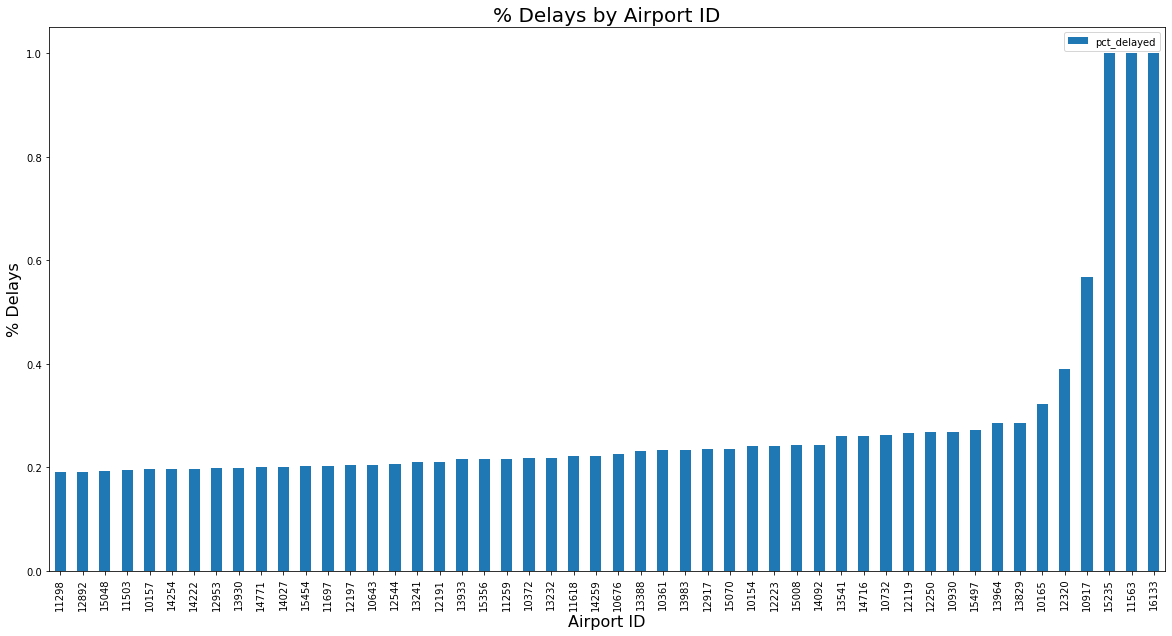

ORIGIN_AIRPORT_ID,Count_By_AirportID,Count_By_AirportID_All,pct_delayed
11298,275542,1447106,0.19040899560916755
12892,231350,1204660,0.19204588846645526
15048,773,4010,0.19276807980049876
11503,2141,10955,0.19543587403012322
10157,1718,8750,0.19634285714285715
14254,828,4211,0.1966278793635716
14222,123,624,0.1971153846153846
12953,140506,709570,0.19801569964908325
13930,334183,1686158,0.19819198438106037
14771,189606,944423,0.2007638526380658


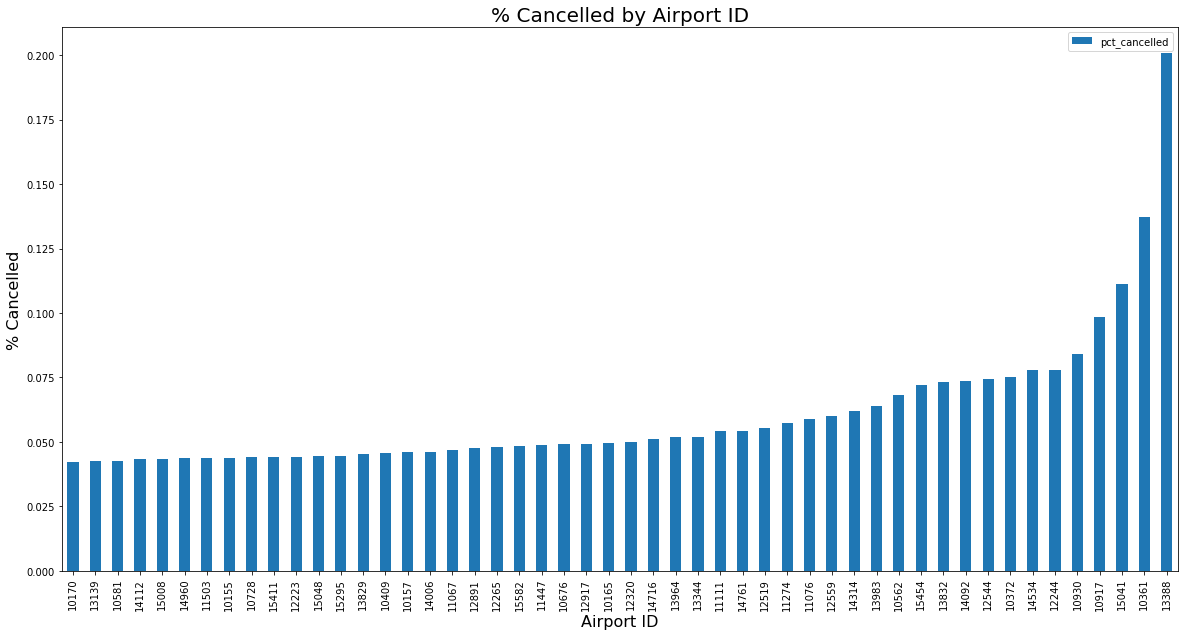

ORIGIN_AIRPORT_ID,Count_By_AirportID,Count_By_AirportID_All,pct_cancelled
10170,145,3425,0.042335766423357665
13139,120,2825,0.04247787610619469
10581,496,11648,0.042582417582417584
14112,970,22397,0.043309371790864845
15008,22,505,0.04356435643564356
14960,243,5564,0.04367361610352265
11503,479,10955,0.043724326791419445
10155,354,8053,0.043958773128026825
10728,182,4137,0.043993231810490696
15411,316,7150,0.0441958041958042


Out[14]: (None, None)

In [0]:
def airport_id_d(df):
  delayed_flights = df.filter("dep_delay_15 == '1'").groupBy('ORIGIN_AIRPORT_ID').count().orderBy('ORIGIN_AIRPORT_ID') \
                      .selectExpr('ORIGIN_AIRPORT_ID', 'count AS Count_By_AirportID')
    
  all_flights = df.groupBy('ORIGIN_AIRPORT_ID').count().orderBy('ORIGIN_AIRPORT_ID') \
                  .selectExpr('ORIGIN_AIRPORT_ID', 'count AS Count_By_AirportID_All')
    
  df = delayed_flights.join(all_flights,['ORIGIN_AIRPORT_ID']).orderBy('ORIGIN_AIRPORT_ID') \
                      .withColumn('pct_delayed', (f.col('Count_By_AirportID') / f.col('Count_By_AirportID_All'))) \
                      .orderBy('pct_delayed').toPandas().tail(50)

  
  ax = df.plot(kind='bar', x='ORIGIN_AIRPORT_ID', y='pct_delayed', stacked=False, figsize = (20, 10))
  
  ax.set_title('% Delays by Airport ID', fontsize = 20)
  ax.set_xlabel("Airport ID", fontsize = 16)
  ax.set_ylabel("% Delays", fontsize = 16)

  return plt.show(), display(df)


def airport_id_c(df):
  cancelled_flights = df.filter("CANCELLED == '1'").groupBy('ORIGIN_AIRPORT_ID').count().orderBy('ORIGIN_AIRPORT_ID') \
                        .selectExpr('ORIGIN_AIRPORT_ID', 'count AS Count_By_AirportID')
    
  all_flights = df.groupBy('ORIGIN_AIRPORT_ID').count().orderBy('ORIGIN_AIRPORT_ID') \
                  .selectExpr('ORIGIN_AIRPORT_ID', 'count AS Count_By_AirportID_All')
    
  df = cancelled_flights.join(all_flights,['ORIGIN_AIRPORT_ID']).orderBy('ORIGIN_AIRPORT_ID') \
                      .withColumn('pct_cancelled', (f.col('Count_By_AirportID') / f.col('Count_By_AirportID_All'))) \
                      .orderBy('pct_cancelled').toPandas().tail(50)

  
  ax = df.plot(kind='bar', x='ORIGIN_AIRPORT_ID', y='pct_cancelled', stacked=False, figsize = (20, 10))
  
  ax.set_title('% Cancelled by Airport ID', fontsize = 20)
  ax.set_xlabel("Airport ID", fontsize = 16)
  ax.set_ylabel("% Cancelled", fontsize = 16)

  return plt.show(), display(df)


airport_id_d(df)
airport_id_c(df)

In [0]:
de1 = df.filter((df.ORIGIN_AIRPORT_ID == "16133") | (df.ORIGIN_AIRPORT_ID == "11563") | (df.ORIGIN_AIRPORT_ID == "15235") \
               | (df.ORIGIN_AIRPORT_ID == "10917") | (df.ORIGIN_AIRPORT_ID == "12320"))

de2 = df.filter((df.ORIGIN_AIRPORT_ID == "10917")).groupBy('Month').count().selectExpr('Month', 'count AS Count_All')
de3 = df.filter((df.ORIGIN_AIRPORT_ID == "10917") & (df.dep_delay_15 == '1')).groupBy('Month').count().selectExpr('Month', 'count AS Count_Delay')
de4 = de3.join(de2,['Month']).orderBy('Month').withColumn('pct_delayed', (f.col('Count_Delay') / f.col('Count_All'))).orderBy('Month').toPandas()
display(de1)
display(de4)

local_timestamp,timezone,scheduled_departure_UTC,rounded_depTimestamp,label,Year,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME_BLK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,dep_delay_15,DEP_DELAY_NEW,CANCELLED,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,elevation_ft,type,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DISTANCE,DISTANCE_GROUP,holiday,holiday_in2DayRange,C19,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,scheduled_departure_UTC_minus_1hr,scheduled_departure_UTC_add_2hr,origin_HourlyAltimeterSetting,origin_HourlyDewPointTemperature,origin_HourlyDryBulbTemperature,origin_HourlyPrecipitation,origin_HourlyPressureChange,origin_HourlyPressureTendency,origin_HourlyRelativeHumidity,origin_HourlySkyConditions,origin_HourlySkyConditions_SCT_cnt,origin_HourlySkyConditions_OVC_cnt,origin_HourlySkyConditions_FEW_cnt,origin_HourlySkyConditions_BKN_cnt,origin_HourlySkyConditions_VV_cnt,origin_HourlySkyConditions_SKC_cnt,origin_HourlySkyConditions_CLR_cnt,origin_HourlySeaLevelPressure,origin_HourlyStationPressure,origin_HourlyVisibility,origin_HourlyWetBulbTemperature,origin_HourlyWindDirection,origin_HourlyWindGustSpeed,origin_HourlyWindSpeed,dest_HourlyAltimeterSetting,dest_HourlyDewPointTemperature,dest_HourlyDryBulbTemperature,dest_HourlyPrecipitation,dest_HourlyPressureChange,dest_HourlyPressureTendency,dest_HourlyRelativeHumidity,dest_HourlySkyConditions,dest_HourlySkyConditions_SCT_cnt,dest_HourlySkyConditions_OVC_cnt,dest_HourlySkyConditions_FEW_cnt,dest_HourlySkyConditions_BKN_cnt,dest_HourlySkyConditions_VV_cnt,dest_HourlySkyConditions_SKC_cnt,dest_HourlySkyConditions_CLR_cnt,dest_HourlySeaLevelPressure,dest_HourlyStationPressure,dest_HourlyVisibility,dest_HourlyWetBulbTemperature,dest_HourlyWindDirection,dest_HourlyWindGustSpeed,dest_HourlyWindSpeed,roundedMonth,no_delays_last3m,no_cancellation_last3m,count_flights_last3m,perc_delays_last3m,perc_cancellation_last3m
2015-01-01T16:13:00.000+0000,America/New_York,2015-01-01T21:13:00.000+0000,2015-01-01T21:00:00.000+0000,1,2015,1,1,1,4,1600-1659,F9,N908FR,1221,1,36,0,12320,ILG,"Wilmington, DE",DE,80,medium_airport,13204,MCO,"Orlando, FL",FL,841,4,1,1,0,0,0,0,0,21,2015-01-01T20:13:00.000+0000,2015-01-01T23:13:00.000+0000,30.05,14,42,0.0,0.06,6,32,CLR:00,0,0,0,0,0,0,1,30.05,29.96,10.0,32,230,30,15,30.05,18,35,0.0,0.0,8,50,CLR:00,0,0,0,0,0,0,1,30.05,29.96,10.0,29,200,28,9,2015-01-01T00:00:00.000+0000,28,0,148,0.1891891891891892,0.0
2015-01-02T09:27:00.000+0000,America/New_York,2015-01-02T14:27:00.000+0000,2015-01-02T14:00:00.000+0000,1,2015,1,1,2,5,0900-0959,F9,N921FR,1217,1,146,0,12320,ILG,"Wilmington, DE",DE,80,medium_airport,15304,TPA,"Tampa, FL",FL,899,4,0,1,0,0,0,129,0,1,2015-01-02T13:27:00.000+0000,2015-01-02T16:27:00.000+0000,30.26,17,35,0.0,0.06,6,48,CLR:00,0,0,0,0,0,0,1,30.26,30.17,10.0,29,250,30,3,30.28,19,43,0.0,0.03,5,38,CLR:00,0,0,0,0,0,0,1,30.28,30.19,10.0,34,270,28,14,2015-01-01T00:00:00.000+0000,31,1,154,0.2012987012987013,0.006493506493506494
2015-01-04T16:13:00.000+0000,America/New_York,2015-01-04T21:13:00.000+0000,2015-01-04T21:00:00.000+0000,1,2015,1,1,4,7,1600-1659,F9,N924FR,1221,1,19,0,12320,ILG,"Wilmington, DE",DE,80,medium_airport,13204,MCO,"Orlando, FL",FL,841,4,0,0,0,3,0,9,0,16,2015-01-04T20:13:00.000+0000,2015-01-04T23:13:00.000+0000,29.74,53,57,0.0,0.06,6,87,CLR:00,0,0,0,0,0,0,1,29.74,29.65,10.0,55,230,30,9,29.71,55,60,0.0,0.03,5,84,BKN:07 32 OVC:08 80,0,1,0,1,0,0,0,29.71,29.62,10.0,57,290,28,9,2015-01-01T00:00:00.000+0000,33,0,166,0.19879518072289157,0.0
2015-01-05T09:27:00.000+0000,America/New_York,2015-01-05T14:27:00.000+0000,2015-01-05T14:00:00.000+0000,1,2015,1,1,5,1,0900-0959,F9,N931FR,1217,1,272,0,12320,ILG,"Wilmington, DE",DE,80,medium_airport,15304,TPA,"Tampa, FL",FL,899,4,0,0,0,272,0,7,0,0,2015-01-05T13:27:00.000+0000,2015-01-05T16:27:00.000+0000,30.2,21,38,0.0,999.0,999,51,OVC:08 55,0,1,0,0,0,0,0,30.2,30.11,10.0,32,300,30,21,30.24,20,38,0.0,-0.01,2,48,BKN:07 50 OVC:08 65,0,1,0,1,0,0,0,3

Month,Count_Delay,Count_All,pct_delayed
5,4,10,0.4
6,9,16,0.5625
7,10,18,0.5555555555555556
8,6,18,0.3333333333333333
9,14,18,0.7777777777777778
10,14,18,0.7777777777777778
11,8,16,0.5
12,10,18,0.5555555555555556


In [0]:
de1 = df.filter((df.ORIGIN_AIRPORT_ID == "10930") | (df.ORIGIN_AIRPORT_ID == "10917") | (df.ORIGIN_AIRPORT_ID == "15041") \
               | (df.ORIGIN_AIRPORT_ID == "10361") | (df.ORIGIN_AIRPORT_ID == "13388")).select('ORIGIN_AIRPORT_ID', 'ORIGIN').distinct()   

de2 = df.filter((df.ORIGIN_AIRPORT_ID == "10930")).groupBy('Month').count().selectExpr('Month', 'count AS Count_All')
de3 = df.filter((df.ORIGIN_AIRPORT_ID == "10930") & (df.CANCELLED == '1')).groupBy('Month').count().selectExpr('Month', 'count AS Count_Cancelled')
de4 = de3.join(de2,['Month']).orderBy('Month').withColumn('pct_cancelled', (f.col('Count_Cancelled') / f.col('Count_All'))).orderBy('Month').toPandas()
display(de1)
display(de4)

ORIGIN_AIRPORT_ID,ORIGIN
15041,SUN
13388,MMH
10917,CDB
10361,ART
10930,CEC


Month,Count_Cancelled,Count_All,pct_cancelled
1,1,60,0.016666666666666666
2,7,56,0.125
3,8,62,0.12903225806451613


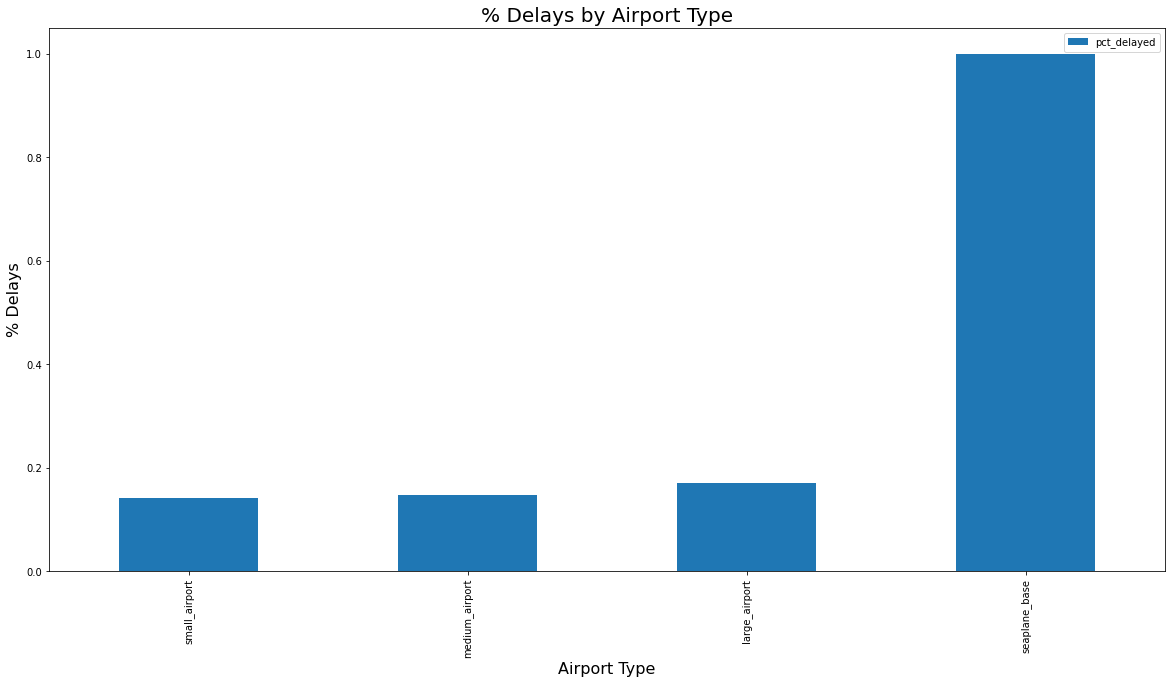

type,Count_Type,Count_Type_All,pct_delayed
small_airport,9479,66944,0.14159596080305928
medium_airport,942384,6360161,0.1481698340655213
large_airport,5140548,29992831,0.1713925571080636
seaplane_base,1,1,1.0


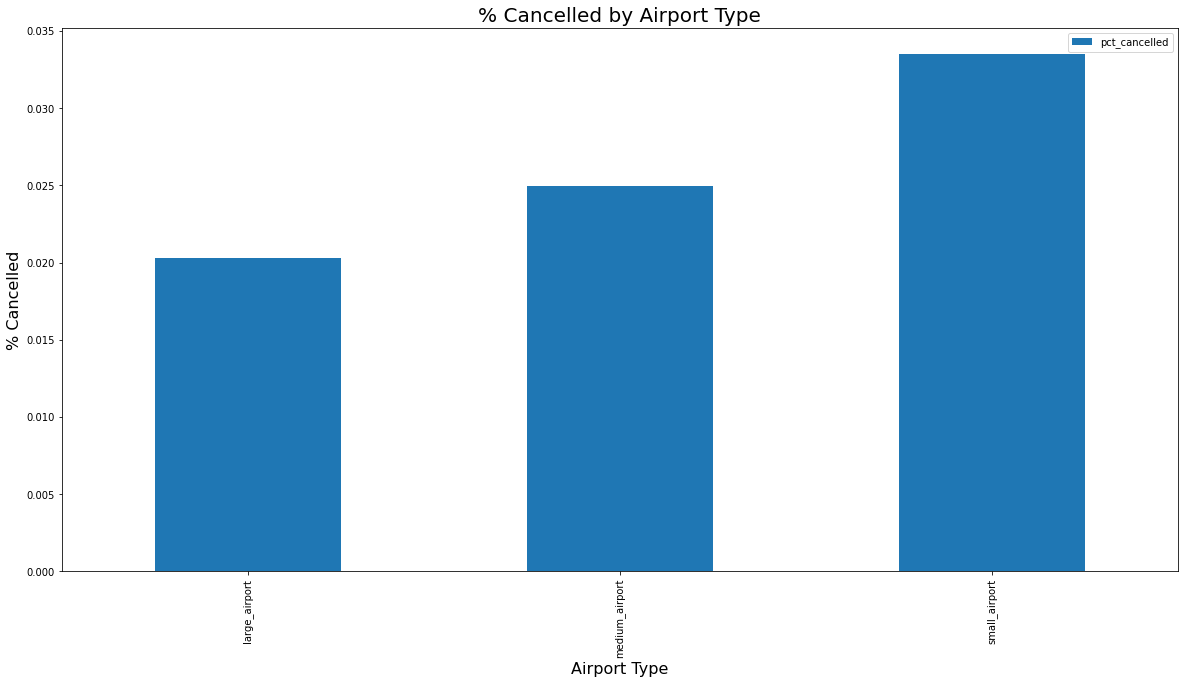

type,Count_Type,Count_Type_All,pct_cancelled
large_airport,609754,29992831,0.020329991523641098
medium_airport,158727,6360161,0.02495644371266702
small_airport,2245,66944,0.033535492351816444


Out[11]: (None, None)

In [0]:
def type_d(df):
  delayed_flights = df.filter("dep_delay_15 == '1'").groupBy('type').count().orderBy('type') \
                      .selectExpr('type', 'count AS Count_Type')
    
  all_flights = df.groupBy('type').count().orderBy('type') \
                  .selectExpr('type', 'count AS Count_Type_All')
    
  df = delayed_flights.join(all_flights,['type']).orderBy('type') \
                      .withColumn('pct_delayed', (f.col('Count_Type') / f.col('Count_Type_All'))) \
                      .orderBy('pct_delayed').toPandas().tail(50)

  
  ax = df.plot(kind='bar', x='type', y='pct_delayed', stacked=False, figsize = (20, 10))
  
  ax.set_title('% Delays by Airport Type', fontsize = 20)
  ax.set_xlabel("Airport Type", fontsize = 16)
  ax.set_ylabel("% Delays", fontsize = 16)

  return plt.show(), display(df)


def type_c(df):
  cancelled_flights = df.filter("CANCELLED == '1'").groupBy('type').count().orderBy('type') \
                        .selectExpr('type', 'count AS Count_Type')
    
  all_flights = df.groupBy('type').count().orderBy('type') \
                  .selectExpr('type', 'count AS Count_Type_All')
    
  df = cancelled_flights.join(all_flights,['type']).orderBy('type') \
                      .withColumn('pct_cancelled', (f.col('Count_Type') / f.col('Count_Type_All'))) \
                      .orderBy('pct_cancelled').toPandas().tail(50)

  
  ax = df.plot(kind='bar', x='type', y='pct_cancelled', stacked=False, figsize = (20, 10))
  
  ax.set_title('% Cancelled by Airport Type', fontsize = 20)
  ax.set_xlabel("Airport Type", fontsize = 16)
  ax.set_ylabel("% Cancelled", fontsize = 16)
  
  return plt.show(), display(df)

type_d(df)
type_c(df)

In [0]:
de1 = df.filter("type == 'seaplane_base'")
display(de1)

local_timestamp,timezone,scheduled_departure_UTC,rounded_depTimestamp,label,Year,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME_BLK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,dep_delay_15,DEP_DELAY_NEW,CANCELLED,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,elevation_ft,type,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DISTANCE,DISTANCE_GROUP,holiday,holiday_in2DayRange,C19,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,scheduled_departure_UTC_minus_1hr,scheduled_departure_UTC_add_2hr,origin_HourlyAltimeterSetting,origin_HourlyDewPointTemperature,origin_HourlyDryBulbTemperature,origin_HourlyPrecipitation,origin_HourlyPressureChange,origin_HourlyPressureTendency,origin_HourlyRelativeHumidity,origin_HourlySkyConditions,origin_HourlySkyConditions_SCT_cnt,origin_HourlySkyConditions_OVC_cnt,origin_HourlySkyConditions_FEW_cnt,origin_HourlySkyConditions_BKN_cnt,origin_HourlySkyConditions_VV_cnt,origin_HourlySkyConditions_SKC_cnt,origin_HourlySkyConditions_CLR_cnt,origin_HourlySeaLevelPressure,origin_HourlyStationPressure,origin_HourlyVisibility,origin_HourlyWetBulbTemperature,origin_HourlyWindDirection,origin_HourlyWindGustSpeed,origin_HourlyWindSpeed,dest_HourlyAltimeterSetting,dest_HourlyDewPointTemperature,dest_HourlyDryBulbTemperature,dest_HourlyPrecipitation,dest_HourlyPressureChange,dest_HourlyPressureTendency,dest_HourlyRelativeHumidity,dest_HourlySkyConditions,dest_HourlySkyConditions_SCT_cnt,dest_HourlySkyConditions_OVC_cnt,dest_HourlySkyConditions_FEW_cnt,dest_HourlySkyConditions_BKN_cnt,dest_HourlySkyConditions_VV_cnt,dest_HourlySkyConditions_SKC_cnt,dest_HourlySkyConditions_CLR_cnt,dest_HourlySeaLevelPressure,dest_HourlyStationPressure,dest_HourlyVisibility,dest_HourlyWetBulbTemperature,dest_HourlyWindDirection,dest_HourlyWindGustSpeed,dest_HourlyWindSpeed,roundedMonth,no_delays_last3m,no_cancellation_last3m,count_flights_last3m,perc_delays_last3m,perc_cancellation_last3m
2017-01-06T23:00:00.000+0000,America/Sitka,2017-01-07T08:00:00.000+0000,2017-01-07T08:00:00.000+0000,1,2017,1,1,6,5,2300-2359,EV,N672AE,2767,1,45,0,15235,TKI,"Tokeen, AK",AK,-9999,seaplane_base,15401,TXK,"Texarkana, AR",AR,2429,10,0,0,0,0,0,0,0,0,2017-01-07T07:00:00.000+0000,2017-01-07T10:00:00.000+0000,99999.0,9999,9999,99.0,999.0,999,99,no_data,-2,-2,-2,-2,-2,-2,-2,99999.0,99999.0,999999.0,9999,99999,9999,99999,99999.0,9999,9999,99.0,999.0,999,99,no_data,-2,-2,-2,-2,-2,-2,-2,99999.0,99999.0,999999.0,9999,99999,9999,99999,2017-01-01T00:00:00.000+0000,115,22,549,0.20947176684881602,0.04007285974499089


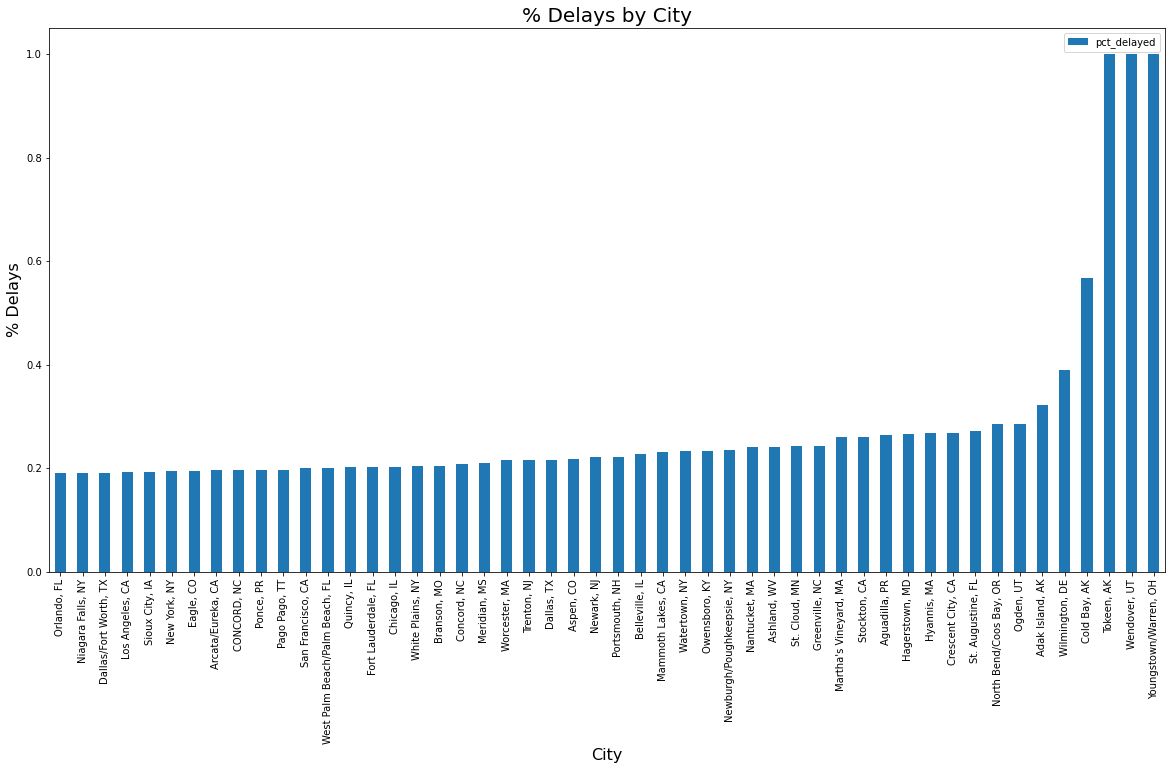

ORIGIN_CITY_NAME,Count_By_City,Count_By_City_All,pct_delayed
"Orlando, FL",143511,755176,0.19003649480386028
"Niagara Falls, NY",664,3489,0.19031241043278876
"Dallas/Fort Worth, TX",275542,1447106,0.19040899560916755
"Los Angeles, CA",231350,1204660,0.19204588846645526
"Sioux City, IA",773,4010,0.19276807980049876
"New York, NY",255449,1317810,0.19384357380806033
"Eagle, CO",2141,10955,0.19543587403012322
"Arcata/Eureka, CA",1718,8750,0.19634285714285715
"CONCORD, NC",22,112,0.19642857142857142
"Ponce, PR",828,4211,0.1966278793635716


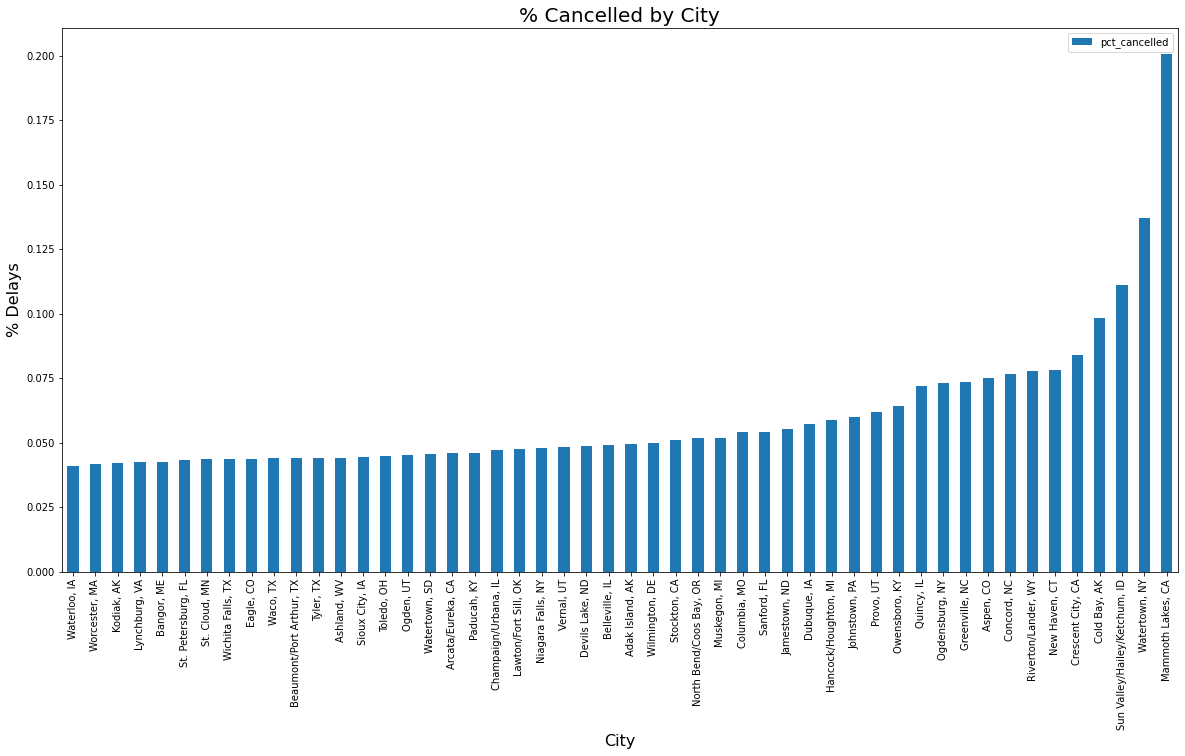

ORIGIN_CITY_NAME,Count_By_City,Count_By_City_All,pct_cancelled
"Waterloo, IA",123,2987,0.04117843990626046
"Worcester, MA",207,4936,0.04193679092382496
"Kodiak, AK",145,3425,0.042335766423357665
"Lynchburg, VA",120,2825,0.04247787610619469
"Bangor, ME",496,11648,0.042582417582417584
"St. Petersburg, FL",970,22397,0.043309371790864845
"St. Cloud, MN",22,505,0.04356435643564356
"Wichita Falls, TX",243,5564,0.04367361610352265
"Eagle, CO",479,10955,0.043724326791419445
"Waco, TX",354,8053,0.043958773128026825


Out[70]: (None, None)

In [0]:
def city_d(df):
  delayed_flights = df.filter("dep_delay_15 == '1'").groupBy('ORIGIN_CITY_NAME').count().orderBy('ORIGIN_CITY_NAME') \
                      .selectExpr('ORIGIN_CITY_NAME', 'count AS Count_By_City')
    
  all_flights = df.groupBy('ORIGIN_CITY_NAME').count().orderBy('ORIGIN_CITY_NAME') \
                  .selectExpr('ORIGIN_CITY_NAME', 'count AS Count_By_City_All')
    
  df = delayed_flights.join(all_flights,['ORIGIN_CITY_NAME']).orderBy('ORIGIN_CITY_NAME') \
                      .withColumn('pct_delayed', (f.col('Count_By_City') / f.col('Count_By_City_All'))) \
                      .orderBy('pct_delayed').toPandas().tail(50)

  
  ax = df.plot(kind='bar', x='ORIGIN_CITY_NAME', y='pct_delayed', stacked=False, figsize = (20, 10))
  
  ax.set_title('% Delays by City', fontsize = 20)
  ax.set_xlabel("City", fontsize = 16)
  ax.set_ylabel("% Delays", fontsize = 16)

  return plt.show(), display(df)


def city_c(df):
  cancelled_flights = df.filter("CANCELLED == '1'").groupBy('ORIGIN_CITY_NAME').count().orderBy('ORIGIN_CITY_NAME') \
                        .selectExpr('ORIGIN_CITY_NAME', 'count AS Count_By_City')
    
  all_flights = df.groupBy('ORIGIN_CITY_NAME').count().orderBy('ORIGIN_CITY_NAME') \
                  .selectExpr('ORIGIN_CITY_NAME', 'count AS Count_By_City_All')
    
  df = cancelled_flights.join(all_flights,['ORIGIN_CITY_NAME']).orderBy('ORIGIN_CITY_NAME') \
                        .withColumn('pct_cancelled', (f.col('Count_By_City') / f.col('Count_By_City_All'))) \
                        .orderBy('pct_cancelled').toPandas().tail(50)

  
  ax = df.plot(kind='bar', x='ORIGIN_CITY_NAME', y='pct_cancelled', stacked=False, figsize = (20, 10))
  
  ax.set_title('% Cancelled by City', fontsize = 20)
  ax.set_xlabel("City", fontsize = 16)
  ax.set_ylabel("% Delays", fontsize = 16)

  return plt.show(), display(df)


city_d(df)
city_c(df)

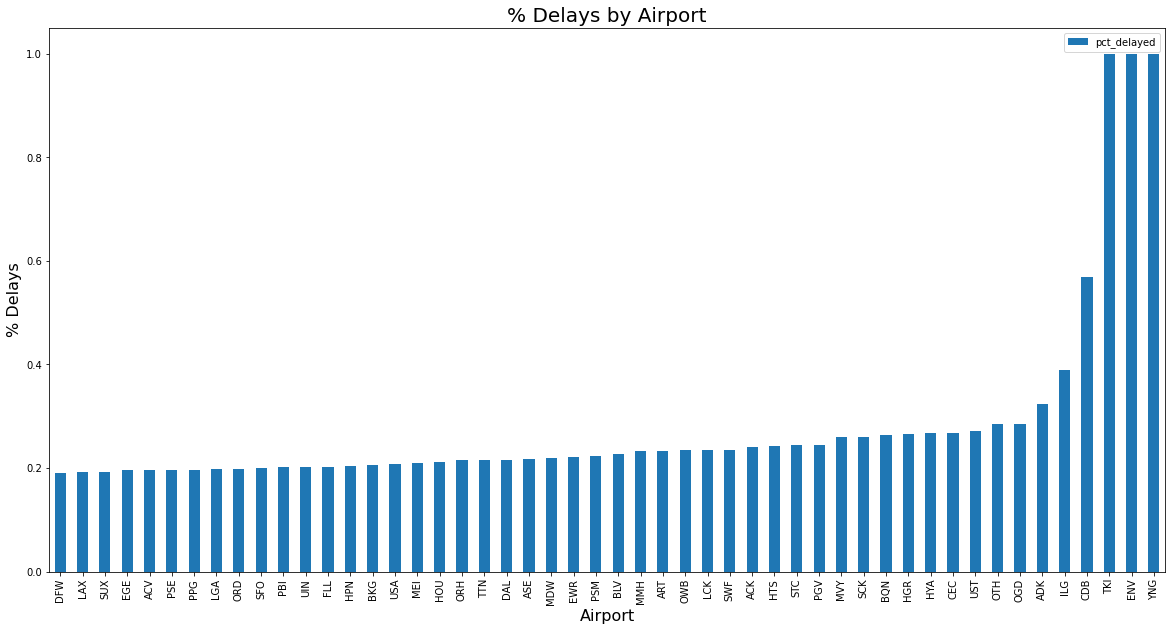

ORIGIN,Count_By_Airport,Count_By_Airport_All,pct_delayed
DFW,275542,1447106,0.19040899560916755
LAX,231350,1204660,0.19204588846645526
SUX,773,4010,0.19276807980049876
EGE,2141,10955,0.19543587403012322
ACV,1718,8750,0.19634285714285715
PSE,828,4211,0.1966278793635716
PPG,123,624,0.1971153846153846
LGA,140506,709570,0.19801569964908325
ORD,334183,1686158,0.19819198438106037
SFO,189606,944423,0.2007638526380658


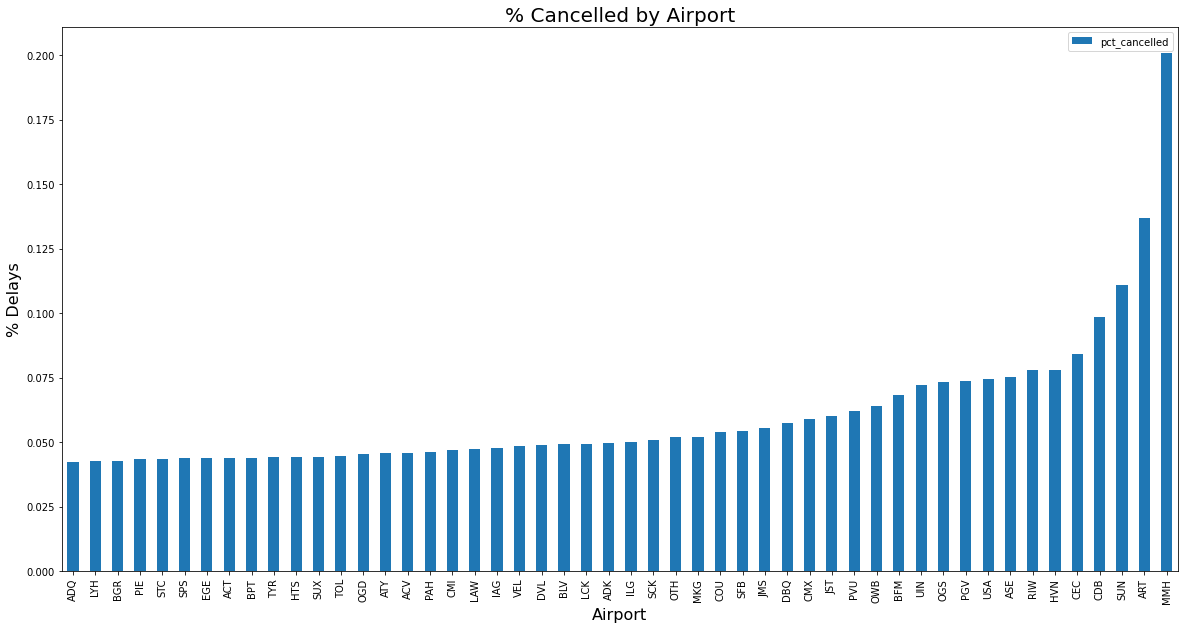

ORIGIN,Count_By_Airport,Count_By_Airport_All,pct_cancelled
ADQ,145,3425,0.042335766423357665
LYH,120,2825,0.04247787610619469
BGR,496,11648,0.042582417582417584
PIE,970,22397,0.043309371790864845
STC,22,505,0.04356435643564356
SPS,243,5564,0.04367361610352265
EGE,479,10955,0.043724326791419445
ACT,354,8053,0.043958773128026825
BPT,182,4137,0.043993231810490696
TYR,316,7150,0.0441958041958042


Out[68]: (None, None)

In [0]:
def airport_d(df):
  delayed_flights = df.filter("dep_delay_15 == '1'").groupBy('ORIGIN').count().orderBy('ORIGIN') \
                      .selectExpr('ORIGIN', 'count AS Count_By_Airport')
    
  all_flights = df.groupBy('ORIGIN').count().orderBy('ORIGIN') \
                  .selectExpr('ORIGIN', 'count AS Count_By_Airport_All')
    
  df = delayed_flights.join(all_flights,['ORIGIN']).orderBy('ORIGIN') \
                      .withColumn('pct_delayed', (f.col('Count_By_Airport') / f.col('Count_By_Airport_All'))) \
                      .orderBy('pct_delayed').toPandas().tail(50)

  
  ax = df.plot(kind='bar', x='ORIGIN', y='pct_delayed', stacked=False, figsize = (20, 10))
  
  ax.set_title('% Delays by Airport', fontsize = 20)
  ax.set_xlabel("Airport", fontsize = 16)
  ax.set_ylabel("% Delays", fontsize = 16)

  return plt.show(), display(df)


def airport_c(df):
  cancelled_flights = df.filter("CANCELLED == '1'").groupBy('ORIGIN').count().orderBy('ORIGIN') \
                        .selectExpr('ORIGIN', 'count AS Count_By_Airport')
    
  all_flights = df.groupBy('ORIGIN').count().orderBy('ORIGIN') \
                  .selectExpr('ORIGIN', 'count AS Count_By_Airport_All')
    
  df = cancelled_flights.join(all_flights,['ORIGIN']).orderBy('ORIGIN') \
                        .withColumn('pct_cancelled', (f.col('Count_By_Airport') / f.col('Count_By_Airport_All'))) \
                        .orderBy('pct_cancelled').toPandas().tail(50)

  
  ax = df.plot(kind='bar', x='ORIGIN', y='pct_cancelled', stacked=False, figsize = (20, 10))
  
  ax.set_title('% Cancelled by Airport', fontsize = 20)
  ax.set_xlabel("Airport", fontsize = 16)
  ax.set_ylabel("% Delays", fontsize = 16)

  return plt.show(), display(df)


airport_d(df)
airport_c(df)

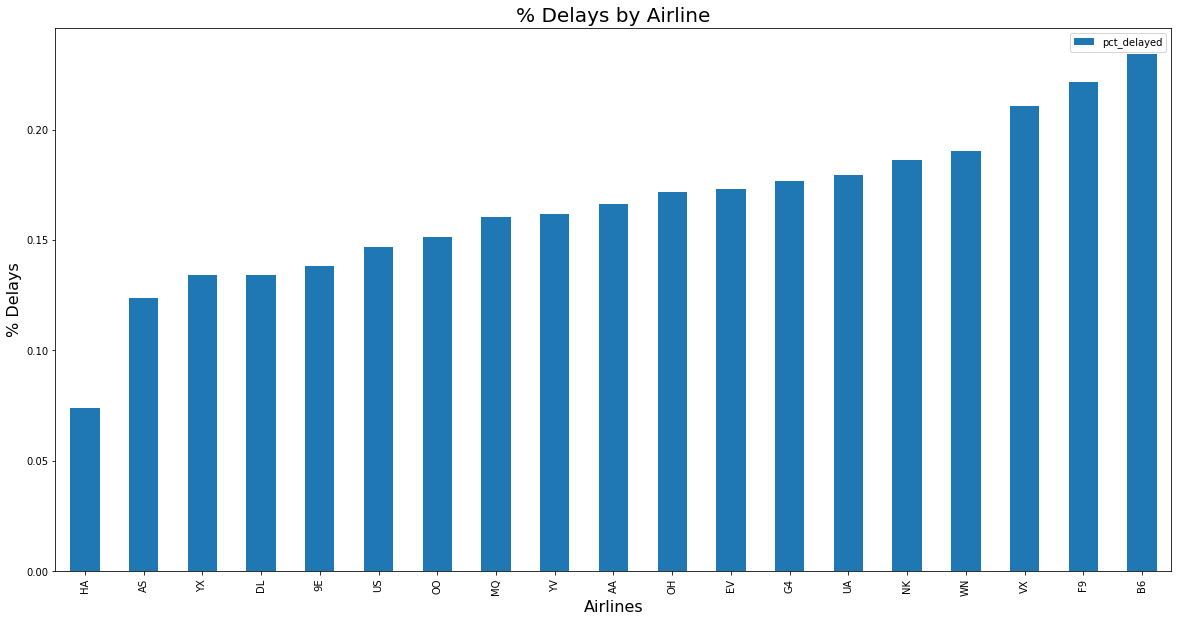

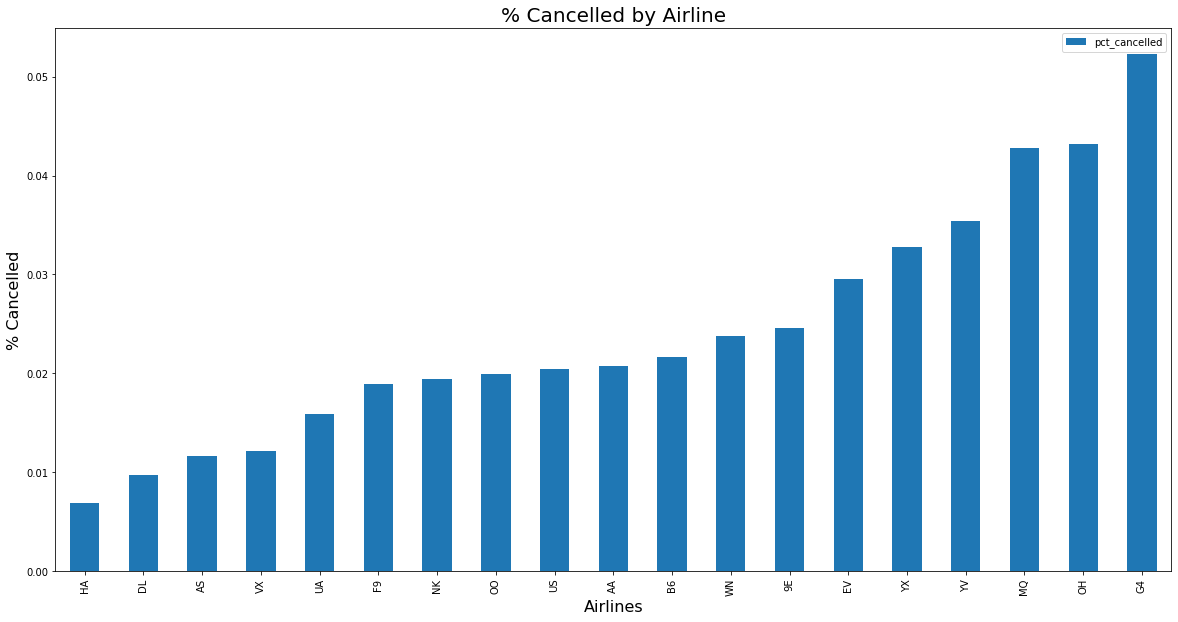

In [0]:
def airline_d(df):
  delayed_flights = df.filter("dep_delay_15 == '1'").groupBy('OP_UNIQUE_CARRIER').count().orderBy('OP_UNIQUE_CARRIER') \
                      .selectExpr('OP_UNIQUE_CARRIER', 'count AS Count_By_Airline')
    
  all_flights = df.groupBy('OP_UNIQUE_CARRIER').count().orderBy('OP_UNIQUE_CARRIER') \
                  .selectExpr('OP_UNIQUE_CARRIER', 'count AS Count_By_Airline_All')
    
  df = delayed_flights.join(all_flights,['OP_UNIQUE_CARRIER']).orderBy('OP_UNIQUE_CARRIER') \
                      .withColumn('pct_delayed', (f.col('Count_By_Airline') / f.col('Count_By_Airline_All'))) \
                      .orderBy('pct_delayed').toPandas()
  
  ax = df.plot(kind='bar', x='OP_UNIQUE_CARRIER', y='pct_delayed', stacked=False, figsize = (20, 10))
  
  ax.set_title('% Delays by Airline', fontsize = 20)
  ax.set_xlabel("Airlines", fontsize = 16)
  ax.set_ylabel("% Delays", fontsize = 16)

  return plt.show()


def airline_c(df):
  cancelled_flights = df.filter("CANCELLED == '1'").groupBy('OP_UNIQUE_CARRIER').count().orderBy('OP_UNIQUE_CARRIER') \
                      .selectExpr('OP_UNIQUE_CARRIER', 'count AS Count_By_Airline')
    
  all_flights = df.groupBy('OP_UNIQUE_CARRIER').count().orderBy('OP_UNIQUE_CARRIER') \
                  .selectExpr('OP_UNIQUE_CARRIER', 'count AS Count_By_Airline_All')
    
  df = cancelled_flights.join(all_flights,['OP_UNIQUE_CARRIER']).orderBy('OP_UNIQUE_CARRIER') \
                      .withColumn('pct_cancelled', (f.col('Count_By_Airline') / f.col('Count_By_Airline_All'))) \
                      .orderBy('pct_cancelled').toPandas()
  
  ax = df.plot(kind='bar', x='OP_UNIQUE_CARRIER', y='pct_cancelled', stacked=False, figsize = (20, 10))
  
  ax.set_title('% Cancelled by Airline', fontsize = 20)
  ax.set_xlabel("Airlines", fontsize = 16)
  ax.set_ylabel("% Cancelled", fontsize = 16)
  
  return plt.show()


airline_d(df)
airline_c(df) 

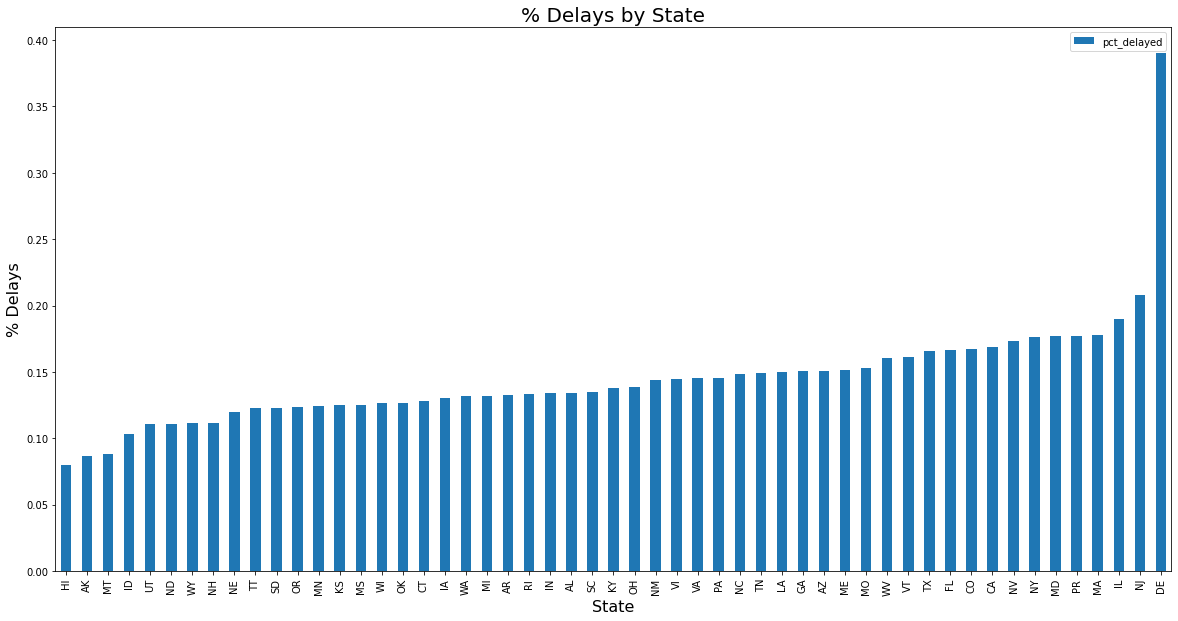

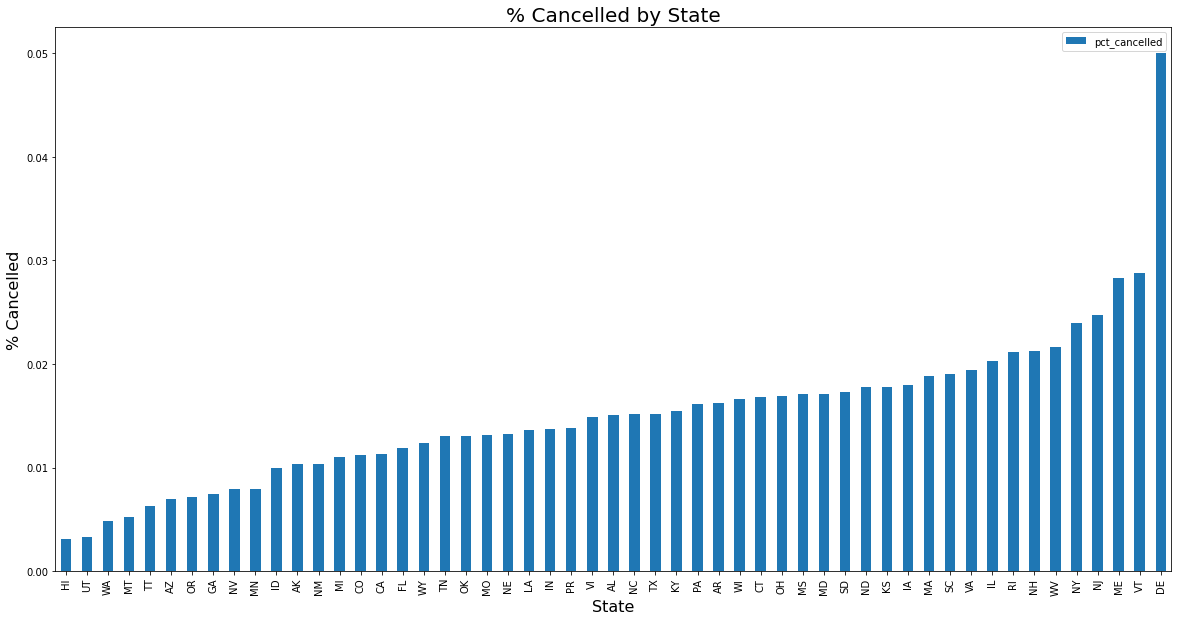

In [0]:
def state_d(df):
  delayed_flights = df.filter("dep_delay_15 == '1'").filter("Year <= '2019'").groupBy('ORIGIN_STATE_ABR').count().orderBy('ORIGIN_STATE_ABR') \
                      .selectExpr('ORIGIN_STATE_ABR', 'count AS Count_By_State')
    
  all_flights = df.groupBy('ORIGIN_STATE_ABR').count().orderBy('ORIGIN_STATE_ABR') \
                  .selectExpr('ORIGIN_STATE_ABR', 'count AS Count_By_State_All')
    
  df = delayed_flights.join(all_flights,['ORIGIN_STATE_ABR']).orderBy('ORIGIN_STATE_ABR') \
                      .withColumn('pct_delayed', (f.col('Count_By_State') / f.col('Count_By_State_All'))) \
                      .orderBy('pct_delayed').toPandas()
  
  ax = df.plot(kind='bar', x='ORIGIN_STATE_ABR', y='pct_delayed', stacked=False, figsize = (20, 10))
  
  ax.set_title('% Delays by State', fontsize = 20)
  ax.set_xlabel("State", fontsize = 16)
  ax.set_ylabel("% Delays", fontsize = 16)

  return plt.show()


def state_c(df):
  cancelled_flights = df.filter("CANCELLED == '1'").filter("Year <= '2019'").groupBy('ORIGIN_STATE_ABR').count().orderBy('ORIGIN_STATE_ABR') \
                      .selectExpr('ORIGIN_STATE_ABR', 'count AS Count_By_State')
    
  all_flights = df.groupBy('ORIGIN_STATE_ABR').count().orderBy('ORIGIN_STATE_ABR') \
                  .selectExpr('ORIGIN_STATE_ABR', 'count AS Count_By_State_All')
    
  df = cancelled_flights.join(all_flights,['ORIGIN_STATE_ABR']).orderBy('ORIGIN_STATE_ABR') \
                      .withColumn('pct_cancelled', (f.col('Count_By_State') / f.col('Count_By_State_All'))) \
                      .orderBy('pct_cancelled').toPandas()
  
  ax = df.plot(kind='bar', x='ORIGIN_STATE_ABR', y='pct_cancelled', stacked=False, figsize = (20, 10))
  
  ax.set_title('% Cancelled by State', fontsize = 20)
  ax.set_xlabel("State", fontsize = 16)
  ax.set_ylabel("% Cancelled", fontsize = 16)
  
  return plt.show()


state_d(df)
state_c(df)

In [0]:
de1 = df.filter("ORIGIN_STATE_ABR == 'DE'").groupBy('Year').count()
de2 = df.filter("ORIGIN_STATE_ABR == 'DE'").groupBy('OP_UNIQUE_CARRIER').count()
de3 = df.filter("ORIGIN_STATE_ABR == 'DE'").select('ORIGIN').distinct()

display(de1)
display(de2)
display(de3)

Year,count
2015,100


OP_UNIQUE_CARRIER,count
F9,100


ORIGIN
ILG


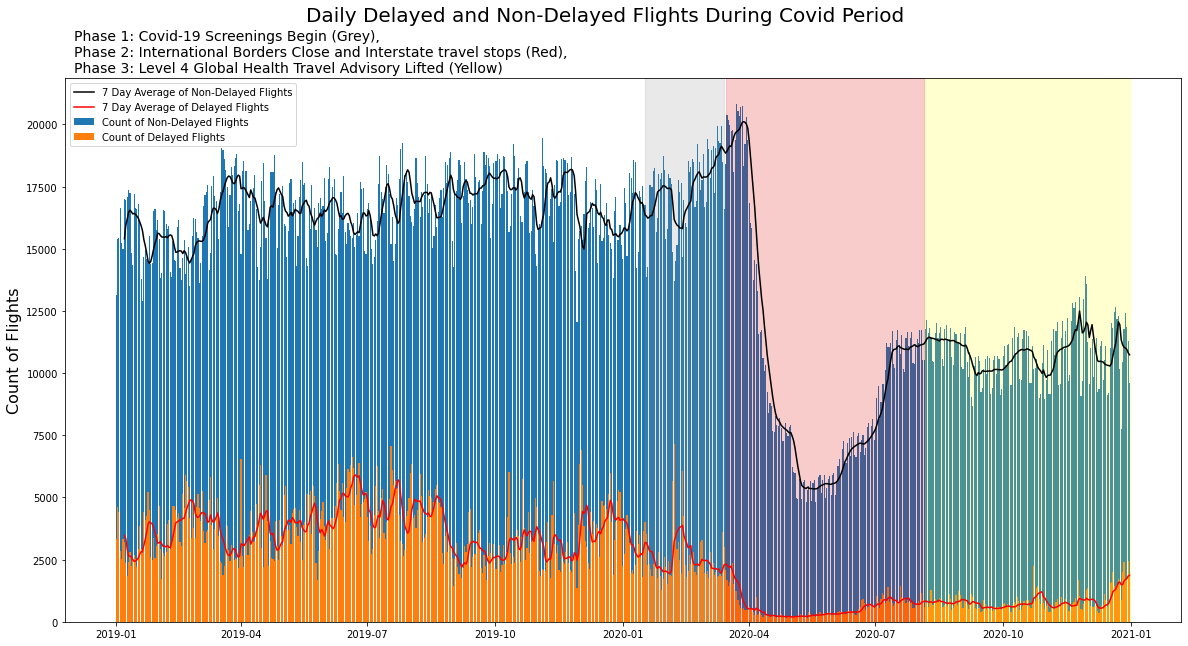

In [0]:
# For distribution graphs
def c19(df, year):
  
  delayed = df.filter(col('Year') >= year).filter(col('dep_delay_15') == 1).withColumn('date',to_date('scheduled_departure_UTC')) \
              .groupBy('date').count().orderBy('date').selectExpr('date AS Date', 'count AS Count_Delayed')
  
  non_delayed = df.filter(col('Year') >= year).filter(col('dep_delay_15') == 0).withColumn('date',to_date('scheduled_departure_UTC')) \
                  .groupBy('date').count().orderBy('date').selectExpr('date AS Date', 'count AS Count_Non_Delayed')
  
  c19 = df.filter(col('Year') >= year).withColumn('date',to_date('scheduled_departure_UTC')).select('date', 'C19').distinct() \
          .orderBy('date').selectExpr('date AS Date', 'C19')
  
  df_join = non_delayed.join(delayed,['Date']).orderBy('Date')
  chart_data = df_join.join(c19,['Date']).orderBy('Date').toPandas()
  
  chart_data['nd_7day_avg'] = chart_data['Count_Non_Delayed'].rolling(7).mean()
  chart_data['d_7day_avg'] = chart_data['Count_Delayed'].rolling(7).mean()

#   fig, ax = plt.subplots()
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(111)

  ax.bar(chart_data['Date'], chart_data['Count_Non_Delayed'], label='Count of Non-Delayed Flights')
  ax.bar(chart_data['Date'], chart_data['Count_Delayed'], label='Count of Delayed Flights')
  ax.plot(chart_data['Date'], chart_data['nd_7day_avg'], label='7 Day Average of Non-Delayed Flights', color = 'black')
  ax.plot(chart_data['Date'], chart_data['d_7day_avg'], label='7 Day Average of Delayed Flights', color = 'red')


#   ax.set_title('''Delayed and Non-Delayed Flights by Day During Covid Period''', fontsize = 20)
#   plt.suptitle('''Phase 1: Covid-19 Screenings Begin (Grey), 
#                  Phase 2: International Borders Close and Interstate travel stops (Red), 
#                  Phase 3: Level 4 Global Health Travel Advisory Lifted (Yellow), 
#                  Phase 4: Vaccinated Passengers Can Travel (Grey)''', fontsize=14,  loc = 'left')
  ax.set_ylabel('Count of Flights', fontsize = 16)
  ax.legend()
  
  ax.axvspan('2020-01-17', '2020-03-14', color=sns.xkcd_rgb['grey'], alpha=0.2)
  ax.axvspan('2020-03-15', '2020-08-05',  color=sns.xkcd_rgb['red'], alpha=0.2)
  ax.axvspan('2020-08-06', '2020-12-31',  color=sns.xkcd_rgb['yellow'], alpha=0.2)
#   ax.axvspan('2020-08-06', '2021-04-01',  color=sns.xkcd_rgb['yellow'], alpha=0.2)
#   ax.axvspan('2021-04-02', '2021-12-31', color=sns.xkcd_rgb['grey'], alpha=0.2)
  
  plt.suptitle("Daily Delayed and Non-Delayed Flights During Covid Period", fontsize = 20)
  plt.title('''
  Phase 1: Covid-19 Screenings Begin (Grey), 
  Phase 2: International Borders Close and Interstate travel stops (Red), 
  Phase 3: Level 4 Global Health Travel Advisory Lifted (Yellow)''', fontsize=14, loc='left')
#   plt.figure(figsize=(25,18))
  
  return plt.show()

c19(df, 2019)

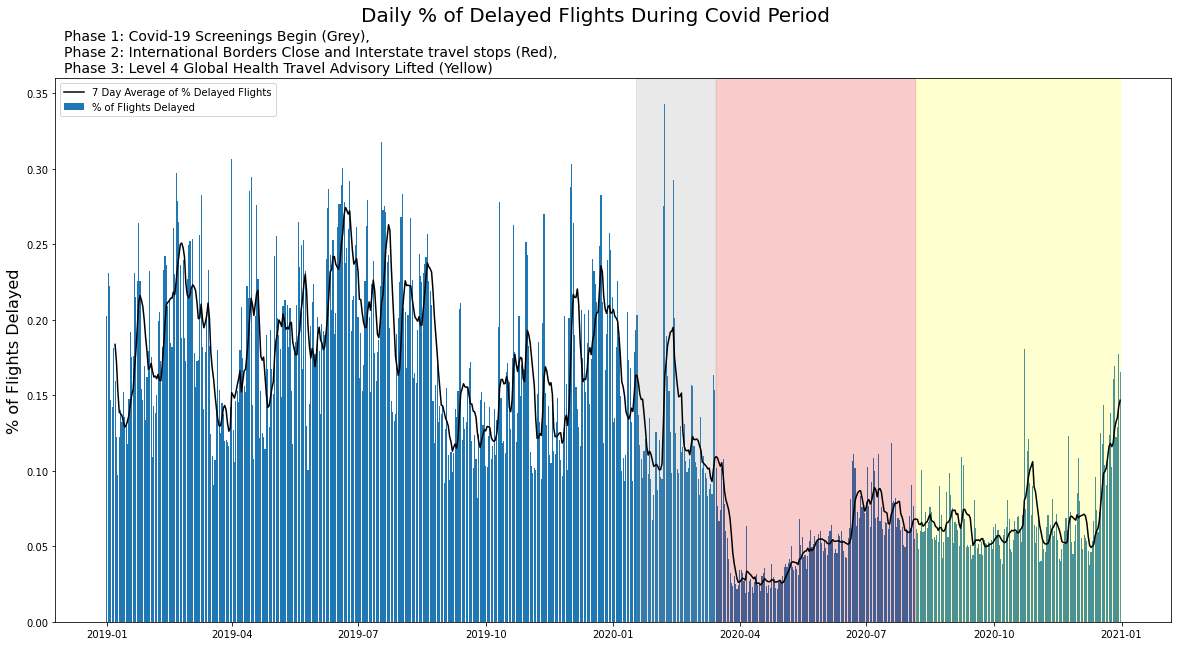

In [0]:
# For distribution graphs
def c19_pct(df, year):
  
  delayed = df.filter(col('Year') >= year).filter(col('dep_delay_15') == 1).withColumn('date',to_date('scheduled_departure_UTC')) \
              .groupBy('date').count().orderBy('date').selectExpr('date AS Date', 'count AS Count_Delayed')
  
  all_flights = df.filter(col('Year') >= year).withColumn('date',to_date('scheduled_departure_UTC')) \
                  .groupBy('date').count().orderBy('date').selectExpr('date AS Date', 'count AS Count_All_Flights')
  
  c19 = df.filter(col('Year') >= year).withColumn('date',to_date('scheduled_departure_UTC')).select('date', 'C19').distinct() \
          .orderBy('date').selectExpr('date AS Date', 'C19')
  
  df_join = all_flights.join(delayed,['Date']).orderBy('Date')
  chart_data = df_join.join(c19,['Date']).orderBy('Date').withColumn('pct_delayed', (f.col('Count_Delayed') / f.col('Count_All_Flights'))).toPandas()
  
  chart_data['pct_delayed_7day_avg'] = chart_data['pct_delayed'].rolling(7).mean()

#   fig, ax = plt.subplots()
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(111)

  ax.bar(chart_data['Date'], chart_data['pct_delayed'], label='% of Flights Delayed')
  ax.plot(chart_data['Date'], chart_data['pct_delayed_7day_avg'], label='7 Day Average of % Delayed Flights', color = 'black')

  ax.set_ylabel('% of Flights Delayed', fontsize = 16)
  ax.legend()
  
  ax.axvspan('2020-01-17', '2020-03-14', color=sns.xkcd_rgb['grey'], alpha=0.2)
  ax.axvspan('2020-03-15', '2020-08-05',  color=sns.xkcd_rgb['red'], alpha=0.2)
  ax.axvspan('2020-08-06', '2020-12-31',  color=sns.xkcd_rgb['yellow'], alpha=0.2)
  #   ax.axvspan('2020-08-06', '2021-04-01',  color=sns.xkcd_rgb['yellow'], alpha=0.2)
#   ax.axvspan('2021-04-02', '2021-12-31', color=sns.xkcd_rgb['grey'], alpha=0.2)
  
  plt.suptitle("Daily % of Delayed Flights During Covid Period", fontsize = 20)
  plt.title('''
  Phase 1: Covid-19 Screenings Begin (Grey), 
  Phase 2: International Borders Close and Interstate travel stops (Red), 
  Phase 3: Level 4 Global Health Travel Advisory Lifted (Yellow)''', fontsize=14, loc='left')
#   plt.figure(figsize=(25,18))
  
  return plt.show()

c19_pct(df, 2019)

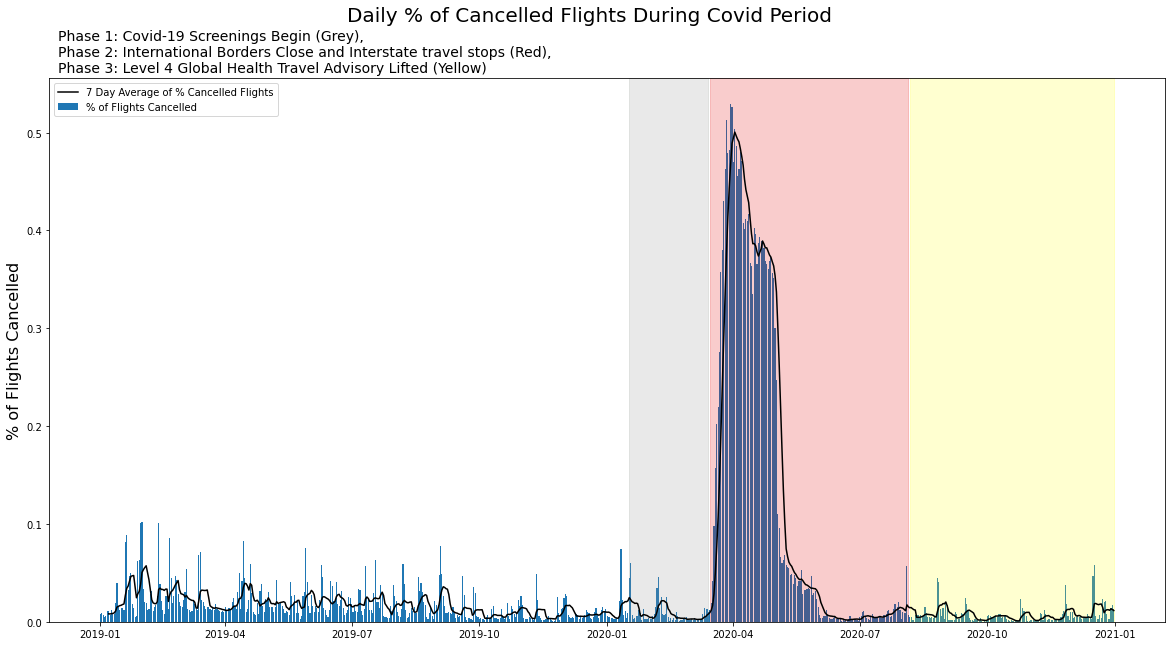

<Figure size 1800x1296 with 0 Axes>

In [0]:
# For distribution graphs
def c19_pct_cancel(df, year):
  
  cancelled = df.filter(col('Year') >= year).filter(col('Cancelled') == 1).withColumn('date',to_date('scheduled_departure_UTC')) \
              .groupBy('date').count().orderBy('date').selectExpr('date AS Date', 'count AS Count_Cancelled')
  
  all_flights = df.filter(col('Year') >= year).withColumn('date',to_date('scheduled_departure_UTC')) \
                  .groupBy('date').count().orderBy('date').selectExpr('date AS Date', 'count AS Count_All_Flights')
  
  c19 = df.filter(col('Year') >= year).withColumn('date',to_date('scheduled_departure_UTC')).select('date', 'C19').distinct() \
          .orderBy('date').selectExpr('date AS Date', 'C19')
  
  df_join = all_flights.join(cancelled,['Date']).orderBy('Date')
  chart_data = df_join.join(c19,['Date']).orderBy('Date').withColumn('pct_cancelled', (f.col('Count_Cancelled') / f.col('Count_All_Flights'))).toPandas()
  
  chart_data['pct_cancelled_7day_avg'] = chart_data['pct_cancelled'].rolling(7).mean()

#   fig, ax = plt.subplots()
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(111)
  
  ax.bar(chart_data['Date'], chart_data['pct_cancelled'], label='% of Flights Cancelled')
  ax.plot(chart_data['Date'], chart_data['pct_cancelled_7day_avg'], label='7 Day Average of % Cancelled Flights', color = 'black')

  ax.set_ylabel('% of Flights Cancelled', fontsize = 16)
  ax.legend()
  
  ax.axvspan('2020-01-17', '2020-03-14', color=sns.xkcd_rgb['grey'], alpha=0.2)
  ax.axvspan('2020-03-15', '2020-08-05',  color=sns.xkcd_rgb['red'], alpha=0.2)
  ax.axvspan('2020-08-06', '2020-12-31',  color=sns.xkcd_rgb['yellow'], alpha=0.2)
#   ax.axvspan('2020-08-06', '2021-04-01',  color=sns.xkcd_rgb['yellow'], alpha=0.2)
#   ax.axvspan('2021-04-02', '2021-12-31', color=sns.xkcd_rgb['grey'], alpha=0.2)
  
  plt.suptitle("Daily % of Cancelled Flights During Covid Period", fontsize = 20)
  plt.title('''
  Phase 1: Covid-19 Screenings Begin (Grey), 
  Phase 2: International Borders Close and Interstate travel stops (Red), 
  Phase 3: Level 4 Global Health Travel Advisory Lifted (Yellow)''', fontsize=14, loc='left')
  plt.figure(figsize=(25,18))
  
  return plt.show()

c19_pct_cancel(df, 2019)

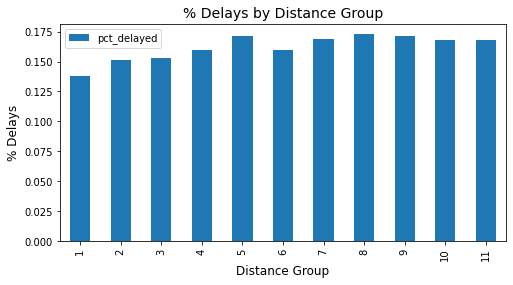

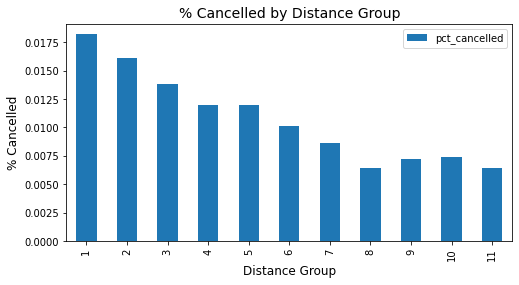

In [0]:
def distance_group_d(df):
  delayed_flights = df.filter("dep_delay_15 == '1'").filter("Year <= '2019'").groupBy('DISTANCE_GROUP').count().orderBy('DISTANCE_GROUP') \
                      .selectExpr('DISTANCE_GROUP', 'count AS Count_Delayed')
    
  all_flights = df.groupBy('DISTANCE_GROUP').count().orderBy('DISTANCE_GROUP') \
                  .selectExpr('DISTANCE_GROUP', 'count AS Count_AllFlights')
    
  df = delayed_flights.join(all_flights,['DISTANCE_GROUP']).orderBy('DISTANCE_GROUP') \
                      .withColumn('pct_delayed', (f.col('Count_Delayed') / f.col('Count_AllFlights'))).toPandas()
  
  ax = df.plot(kind='bar', x='DISTANCE_GROUP', y='pct_delayed', stacked=False, figsize = (8, 4))
  
  ax.set_title('% Delays by Distance Group', fontsize = 14)
  ax.set_xlabel("Distance Group", fontsize = 12)
  ax.set_ylabel("% Delays", fontsize = 12)
  
  return plt.show()


def distance_group_c(df):
  cancelled_flights = df.filter("CANCELLED == '1'").filter("Year <= '2019'").groupBy('DISTANCE_GROUP').count().orderBy('DISTANCE_GROUP') \
                      .selectExpr('DISTANCE_GROUP', 'count AS Count_Cancelled')
    
  all_flights = df.groupBy('DISTANCE_GROUP').count().orderBy('DISTANCE_GROUP') \
                  .selectExpr('DISTANCE_GROUP', 'count AS Count_AllFlights')
    
  df = cancelled_flights.join(all_flights,['DISTANCE_GROUP']).orderBy('DISTANCE_GROUP') \
                        .withColumn('pct_cancelled', (f.col('Count_Cancelled') / f.col('Count_AllFlights'))).toPandas()
  
  ax = df.plot(kind='bar', x='DISTANCE_GROUP', y='pct_cancelled', stacked=False, figsize = (8, 4))
  
  ax.set_title('% Cancelled by Distance Group', fontsize = 14)
  ax.set_xlabel("Distance Group", fontsize = 12)
  ax.set_ylabel("% Cancelled", fontsize = 12)
  
  return plt.show()


distance_group_d(df)
distance_group_c(df)

In [0]:
# Function to create vectors
def create_pipeline(df, inputCols_cat, inputCols_cont):
  """Creates a feature engineering pipeline for modeling 
  Args:
    inputCols_cat (list): list of categorical input cols
    inputCols_cont (list): list of continuous input cols 
  
  Returns: 
    pipeline (Pipeline): MLlib pipeline with stages  
  """

  # String Indexer
  inputCols_categorical_indexed = [f'{i}_index' for i in inputCols_cat]
  string_indexer = StringIndexer(inputCols = inputCols_cat, 
                                 outputCols = inputCols_categorical_indexed).setHandleInvalid('keep')

  # One Hot Encoder  
  inputCols_categorical_encoded = [f'{i}_encoded' for i in inputCols_categorical_indexed]
  one_hot_encoder = OneHotEncoder(inputCols = inputCols_categorical_indexed, 
                                  outputCols = inputCols_categorical_encoded)

  # Vector Assembler 
  inputCols = inputCols_categorical_encoded + inputCols_cont
  assembler = VectorAssembler(inputCols = inputCols, 
                              outputCol = 'features').setHandleInvalid('keep')

  # Pipeline
  return Pipeline().setStages([string_indexer, one_hot_encoder, assembler])

In [0]:
# Define input categorical and continuous cols 
#'holiday', 'holiday_in2DayRange',

# 'DISTANCE_GROUP', 'C19', 'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'type', 'DEST_AIRPORT_ID', 

inputCols_categorical = ['DEST_CITY_NAME', 'DEST_STATE_ABR']
inputCols_continuous = ['dep_delay_15', 'CANCELLED']

pipeline = create_pipeline(df, inputCols_categorical, inputCols_continuous)
pipeline_df = pipeline.fit(df).transform(df)
display(pipeline_df)


# r = ChiSquareTest.test(pipeline_df, "features", 'dep_delay_15').head()
# print("pValues: " + str(r.pValues))
# print("degreesOfFreedom: " + str(r.degreesOfFreedom))
# print("statistics: " + str(r.statistics))

# chiSqResult = ChiSquareTest.test(pipeline_df, 'features', 'dep_delay_15')
# chiSqResult.select("degreesOfFreedom").collect()[0]
# Row(degreesOfFreedom=[3, 1, 0])
# chiSqResult = ChiSquareTest.test(pipeline_df, 'features','dep_delay_15', True)
# row = chiSqResult.orderBy("featureIndex").collect()
# row[0].statistic

# r = ChiSquareTest.test(pipeline_df,  'features', 'dep_delay_15')
# r.show(truncate=False)

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<command-2647101326221889> in <cell line: 10>()
      8 inputCols_continuous = ['dep_delay_15', 'CANCELLED']
      9 
---> 10 pipeline = create_pipeline(df, inputCols_categorical, inputCols_continuous)
     11 pipeline_df = pipeline.fit(df).transform(df)
     12 display(pipeline_df)

<command-2647101326221879> in create_pipeline(df, inputCols_cat, inputCols_cont)
     24   assembler = VectorAssembler(inputCols = inputCols, 
     25                               outputCol = 'features').setHandleInvalid('keep')
---> 26   assembler = DenseVector(assembler)
     27 
     28   # Pipeline

/databricks/spark/python/pyspark/ml/linalg/__init__.py in __init__(self, ar)
    332             ar_ = np.frombuffer(ar, dtype=np.float64)
    333         elif not isinstance(ar, np.ndarray):
--> 334             ar_ = np.array(ar, dtype=np.float64)
    335 

# EDA (II): Trends and Exploration

In [0]:
def summary_stats(df):
  
  stats = df.select('DEP_DELAY', 'DEP_DELAY_NEW', 'DISTANCE', 'elevation_ft', 'Year'
                    'origin_HourlyAltimeterSetting', 'origin_HourlyDewPointTemperature', 'origin_HourlyDryBulbTemperature', 
                    'origin_HourlyPrecipitation', 'origin_HourlyPressureChange', 'origin_HourlyPressureTendency', 'origin_HourlyRelativeHumidity',
                    'origin_HourlySeaLevelPressure', 'origin_HourlyStationPressure', 'origin_HourlyVisibility', 'origin_HourlyWetBulbTemperature',
                    'origin_HourlyWindDirection', 'origin_HourlyWindGustSpeed', 'origin_HourlyWindSpeed',
                    'dest_HourlyAltimeterSetting', 'dest_HourlyDewPointTemperature', 'dest_HourlyDryBulbTemperature', 
                    'dest_HourlyPrecipitation', 'dest_HourlyPressureChange', 'dest_HourlyPressureTendency', 'dest_HourlyRelativeHumidity',
                    'dest_HourlySeaLevelPressure', 'dest_HourlyStationPressure', 'dest_HourlyVisibility', 'dest_HourlyWetBulbTemperature',
                    'dest_HourlyWindDirection', 'dest_HourlyWindGustSpeed', 'dest_HourlyWindSpeed').describe().to_koalas().transpose()
  return stats

In [0]:
def corr_matrix(df, orig):
  
  data = df
  
  if orig == 1:
    corr_matrix = data.select(['DEP_DELAY_NEW', 'CANCELLED', 'DISTANCE', 'elevation_ft', 
                               'origin_HourlyDewPointTemperature', 'origin_HourlyDryBulbTemperature','origin_HourlyPrecipitation', 'origin_HourlyPressureChange', 
                               'origin_HourlyPressureTendency', 'origin_HourlyRelativeHumidity', 'origin_HourlySeaLevelPressure', 'origin_HourlyStationPressure', 
                               'origin_HourlyVisibility', 'origin_HourlyWetBulbTemperature', 'origin_HourlyWindDirection', 'origin_HourlyWindGustSpeed', 
                               'origin_HourlyWindSpeed'])
  else:
    corr_matrix = data.select(['DEP_DELAY_NEW', 'CANCELLED', 'DISTANCE', 'elevation_ft', 
                               'dest_HourlyDewPointTemperature', 'dest_HourlyDryBulbTemperature','dest_HourlyPrecipitation', 'dest_HourlyPressureChange', 
                               'dest_HourlyPressureTendency', 'dest_HourlyRelativeHumidity', 'dest_HourlySeaLevelPressure', 'dest_HourlyStationPressure', 
                               'dest_HourlyVisibility', 'dest_HourlyWetBulbTemperature', 'dest_HourlyWindDirection', 'dest_HourlyWindGustSpeed', 
                               'dest_HourlyWindSpeed'])
    
  df_corr = corr_matrix.select("*").toPandas()

  plt.figure(figsize=(23,10))
  corr = df_corr.corr() 

  # Matplotlib
  fig, ax = plt.subplots(figsize=(18, 12))

  # Colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  cmap='Spectral'

  # Heatmap
  mask = np.triu(np.ones_like(corr, dtype=bool))
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
  return plt.show()

In [0]:
# def histogram_charts(df, year):
#   delayed = df.filter(col('Year') == year).groupBy('DEP_DELAY_GROUP').count().orderBy('DEP_DELAY_GROUP').filter("DEP_DELAY_GROUP is not NULL").toPandas()
#   ax = delayed.plot(kind='bar', x='DEP_DELAY_GROUP', y='count', stacked=False, figsize = (8, 4))
  
#   ax.set_title('Delay Distribution by Group - 15 Min Intervals for {}'.format(year), fontsize = 14)
#   ax.set_xlabel("Departure Delay Group", fontsize = 12)
#   ax.set_ylabel("# of Flights in Millions", fontsize = 12)
  
#   delayed['pct_total'] = delayed['count'] / delayed['count'].sum()
  
#   return plt.show(), display(delayed)

In [0]:
def histogram_delays_time_block(df, year):
  #Delays by Depart Hour
  delayed = df.filter(col('Year') == year).filter("DEP_DELAY >= 15").groupBy('DEP_TIME_BLK').count().orderBy('DEP_TIME_BLK').toPandas()
  ax = delayed.plot(kind='bar', x='DEP_TIME_BLK', y='count', stacked=False, figsize = (8, 4))
  
  ax.set_title('Delay Distribution by Time Block for {}'.format(year), fontsize = 14)
  ax.set_xlabel("Time Block", fontsize = 12)
  ax.set_ylabel("# of Flights in Millions", fontsize = 12)
  
  return plt.show()

In [0]:
def histogram_flights_time_block(df, year):
  #Flights by the Hour
  delayed = df.filter(col('Year') == year).groupBy('DEP_TIME_BLK').count().orderBy('DEP_TIME_BLK').toPandas()
  ax = delayed.plot(kind='bar', x='DEP_TIME_BLK', y='count', stacked=False, figsize = (8, 4))
  
  ax.set_title('Flights by Time Block for {}'.format(year), fontsize = 14)
  ax.set_xlabel("Time Block", fontsize = 12)
  ax.set_ylabel("# of Flights in Millions", fontsize = 12)
  
  return plt.show()

In [0]:
# For distribution graphs
def time_series_charts(df, year):
  
  delayed = df.filter(col('Year') == year).filter(col('dep_delay_15') == 1).groupBy('RoundedDate') \
                .count().orderBy('RoundedDate').selectExpr('RoundedDate AS Date', 'count AS Count_Delayed').toPandas()
  
  non_delayed = df.filter(col('Year') == year).filter(col('dep_delay_15') == 0).groupBy('RoundedDate') \
                .count().orderBy('RoundedDate').selectExpr('RoundedDate AS Date', 'count AS Count_Non_Delayed').toPandas()
  
  chart_data = non_delayed.join(delayed.set_index('Date'), on='Date', sort=True, how='inner')
  chart_data['nd_7day_avg'] = chart_data['Count_Non_Delayed'].rolling(7).mean()
  chart_data['d_7day_avg'] = chart_data['Count_Delayed'].rolling(7).mean()

  fig, ax = plt.subplots()
  plt.figure(figsize=(50,10))   

  ax.bar(chart_data['Date'], chart_data['Count_Non_Delayed'], label='Count of Non-Delayed Flights')
  ax.bar(chart_data['Date'], chart_data['Count_Delayed'], label='Count of Delayed Flights')
  ax.plot(chart_data['Date'], chart_data['nd_7day_avg'], label='7 Day Average of Non-Delayed Flights', color = 'black')
  ax.plot(chart_data['Date'], chart_data['d_7day_avg'], label='7 Day Average of Delayed Flights', color = 'red')

  ax.set_ylabel('Count of Flights')
  ax.set_title('Delayed and Non-Delayed Flights by Day - {} Full Year'.format(year))
  ax.legend()

#   chart_data.plot(kind='bar', x='Date', stacked=True, figsize = (50, 10), title='Delay by Day - {} Full Year'.format(year)) # For Pandas chart

  return plt.show()

In [0]:
def count_2015_2019(df):
  
#   df.createOrReplaceTempView('df')
#   # Number of flights by origin airport
#   df_pivot = sqlContext.sql("""
#   WITH cte as (select 
#                a.MONTH,
#                a.DAY_OF_MONTH,
#                count(a.OP_CARRIER_FL_NUM) as count_flights

#                from df as a
#                group by 1, 2
#                order by 1, 2)
#   select 
#   *
#   from cte  
#   """)

  Window_Spec  = Window.partitionBy().orderBy('MONTH', 'DAY_OF_MONTH')

  delayed = df.filter(to_date('FL_DATE_2') != lit("2016-02-29")).filter(col('Year') < 2020).filter(col('dep_delay_15') == 1) \
              .groupBy('DAY_OF_MONTH','MONTH').count().withColumn('Day_Number',row_number().over(Window_Spec)) \
              .selectExpr('Day_Number','count AS Count_Delayed').toPandas()
  
  non_delayed = df.filter(to_date('FL_DATE_2') != lit("2016-02-29")).filter(col('Year') < 2020).filter(col('dep_delay_15') == 0) \
              .groupBy('DAY_OF_MONTH','MONTH').count().withColumn('Day_Number',row_number().over(Window_Spec)) \
              .selectExpr('Day_Number','count AS Count_Non_Delayed').toPandas()
  
  chart_data = non_delayed.join(delayed.set_index('Day_Number'), on='Day_Number', sort=True, how='inner')
  chart_data['nd_7day_avg'] = chart_data['Count_Non_Delayed'].rolling(7).mean()
  chart_data['d_7day_avg'] = chart_data['Count_Delayed'].rolling(7).mean()

  fig, ax = plt.subplots()
  plt.figure(figsize=(50,10))   

  ax.bar(chart_data['Day_Number'], chart_data['Count_Non_Delayed'], label='Count of Non-Delayed Flights')
  ax.bar(chart_data['Day_Number'], chart_data['Count_Delayed'], label='Count of Delayed Flights')
  ax.plot(chart_data['Day_Number'], chart_data['nd_7day_avg'], label='7 Day Average of Non-Delayed Flights', color = 'black')
  ax.plot(chart_data['Day_Number'], chart_data['d_7day_avg'], label='7 Day Average of Delayed Flights', color = 'red')

  ax.set_ylabel('Count of Flights')
  ax.set_xlabel('Day Number')
  ax.set_title('Delayed and Non-Delayed Flights by Day Number 2015 - 2019')
  ax.legend()

  return plt.show()

In [0]:
def delay_precip(df, year):

  data = df.filter(col('Year') == year).filter(col('dep_delay_15') == 1).select(col('DEP_DELAY'), col('origin_HourlyPrecipitation')).toPandas()
  
  ax = data.plot(kind='scatter', x='DEP_DELAY', y='origin_HourlyPrecipitation', figsize = (50, 10)) # For Pandas chart
  
  ax.set_title('Scatter of Minute Delay by Hourly Precipitation for {}'.format(year), fontsize = 14)
  ax.set_xlabel('Departure Delay in Minutes', fontsize = 12)
  ax.set_ylabel('Hourly Precipitation', fontsize = 12)
  
  return plt.show()


def delay_vis(df, year):

  data = df.filter(col('Year') == year).filter(col('dep_delay_15') == 1).select(col('DEP_DELAY'), col('origin_HourlyVisibility')).toPandas()
  
  ax = data.plot(kind='scatter', x='DEP_DELAY', y='origin_HourlyVisibility', figsize = (50, 10)) # For Pandas chart
  
  ax.set_title('Scatter of Minute Delay by Hourly Visibility for {}'.format(year), fontsize = 14)
  ax.set_xlabel('Departure Delay in Minutes', fontsize = 12)
  ax.set_ylabel('Hourly Visibility', fontsize = 12)
  
  return plt.show()

In [0]:
def null_charts(df, year, dataset):
  df_nulls = df.loc[:, (df != 0).all(axis=0)]
  ax = df_nulls.T.plot(kind='bar', stacked=False, figsize = (16, 8))
  
  ax.set_title('# of Nulls for {} Dataset for {}'.format(dataset, year), fontsize = 14)
  ax.set_xlabel("Dataset Column Name", fontsize = 12)
  ax.set_ylabel("# of Nulls", fontsize = 12)
  ax.get_legend().remove()
  
  return plt.show()

### EDA Graphing

In [0]:
# summary_stats(df)

In [0]:
corr_matrix(df,1)

In [0]:
corr_matrix(df,0)

In [0]:
# histogram_delays_time_block(df, 2016)
# histogram_delays_time_block(df, 2020)

In [0]:
# histogram_flights_time_block(df, 2016)
# histogram_flights_time_block(df, 2020)

In [0]:
# count_2015_2019(df)
# time_series_charts(df, 2020)
# time_series_charts(df, 2021)

In [0]:
# delay_precip(df, 2016)
# delay_precip(df, 2020)

In [0]:
# delay_vis(df, 2016)
# delay_vis(df, 2020)

In [0]:
# null_charts(dfa_2016nulls, 2016, 'Airline')
# null_charts(dfa_2020nulls, 2020, 'Airline')

# null_charts(dfw_2016nulls, 2016, 'Weather')
# null_charts(dfw_2020nulls, 2020, 'Weather')

In [0]:
df.printSchema()

root
 |-- local_timestamp: timestamp (nullable = true)
 |-- timezone: string (nullable = true)
 |-- scheduled_departure_UTC: timestamp (nullable = true)
 |-- rounded_depTimestamp: timestamp (nullable = true)
 |-- label: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- DEP_TIME_BLK: string (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- dep_delay_15: integer (nullable = true)
 |-- DEP_DELAY: integer (nullable = true)
 |-- DEP_DELAY_NEW: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)
 |-- ORIGIN_AIRPORT_ID: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY_NAME: string (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- eleva